<br><br><br>
<h2><font size=6>Práctica 3</font></h2>


<h1><font size=7>Análisis de datos y predicción supervisada</font></h1>


<h1><font size=7></font></h1>

<br>
<div style="text-align: right">
<font size=4>Pablo Torrijos Arenas (Pablo.Torrijos@uclm.es)</font><br>
<font size=4>José Miguel Puerta Callejón (Jose.Puerta@uclm.es)</font><br>
</div>

**<font color="#B30033" size=5>Estudiantes: </font>** 

* Diego García Díaz
* Alberto Pérez Álvarez

---

# 1. Introducción

El objetivo de esta práctica es realizar un análisis completo de un problema de mantenimiento predictivo industrial, desde la exploración inicial hasta la generación de predicciones, aplicando modelos supervisados como árboles de decisión y Naive Bayes.

Se proporciona un conjunto de datos sintético que simula lecturas de sensores en condiciones industriales reales, incluyendo variables numéricas, categóricas y posibles patrones temporales. A diferencia de prácticas anteriores, no se especifica el contexto exacto, fomentando una interpretación autónoma de los datos y la toma de decisiones basada en evidencia.

El proceso incluye: carga, exploración, preprocesamiento, entrenamiento, evaluación y predicción sobre un conjunto de test. La evaluación final se realizará mediante una competición en Kaggle, usando el `F1-score` como métrica principal.

### 1.1. Datos

Se entregan tres archivos: 
- `train.csv`: Observaciones etiquetadas, con múltiples variables técnicas y la variable objetivo `fallo`, binaria (valores `1` (fallo) o `0` (normal)) y desbalanceada (alrededor de un 25% de fallos).
- `test.csv`: Observaciones sin etiqueta para evaluación.
- `sample_submission.csv`: Ejemplo de cómo hay que formatear la solución para subir a la competición de Kaggle.

Los datos deben tratarse como una caja negra: no se da información adicional sobre su origen. Se espera que el análisis determine el tratamiento más adecuado para cada variable, ya que pueden contener artefactos realistas como valores faltantes o ruido.

### 1.2. Desarrollo

El flujo de trabajo seguirá, de forma general, las siguientes etapas:

- **Análisis exploratorio** (*EDA - Exploratory Data Analysis*): distribución de la variable objetivo, comportamiento de las variables, relaciones entre ellas... identificando patrones, relaciones e irregularidades.

  > A veces es necesario incluir en esta sección alguna parte del preprocesamiento (por ejemplo, la creación de una variable nueva) para analizarla gráficamente.

- **Preprocesamiento** (*Feature Engineering, Data Cleaning...*): tratar los valores faltantes, codificar variables categóricas (*ej. one-hot*) o numéricas (*ej. discretización*), normalización si es necesaria, ...

- **Modelización**: al menos dos algoritmos de clasificación, comparando su rendimiento.

- **Predicción y evaluación**: aplicar el mejor modelo al conjunto de test y generar predicciones. Participación en una competición privada en Kaggle, usando `F1-score` como métrica principal. El objetivo es maximizar el `F1-score`, que es especialmente relevante debido al desbalance en los datos.

### 1.3 Competición de Kaggle

El enlace a la competición es [https://www.kaggle.com/competitions/sbc-2025](https://www.kaggle.com/competitions/sbc-2025). En este enlace encontraréis más detalles sobre el funcionamiento de la competición, los datos proporcionados y cómo presentar las soluciones.

Kaggle es una plataforma en línea que alberga competiciones de ciencia de datos, donde los participantes pueden resolver problemas reales utilizando técnicas de análisis de datos y aprendizaje automático. En esta plataforma, los equipos o participantes compiten para crear los mejores modelos predictivos, y sus soluciones son evaluadas en función de su rendimiento en un conjunto de datos de prueba. 

En esta competición, los equipos (de 1 o 2 personas) con mejor rendimiento recibirán una bonificación en la nota final de la siguiente manera:

- **1er puesto:** +0.75 puntos
- **2º puesto:** +0.5 puntos
- **3er puesto:** +0.25 puntos

**Nota:** Las bonificaciones estarán sujetas a revisión en función del cumplimiento de las reglas de la competición y la calidad de las soluciones presentadas. Los equipos pueden ser requeridos a justificar su enfoque durante entrevistas personales para verificar el entendimiento y la originalidad de su modelo.


### 1.4. Entregables

Se entregará un **notebook en Jupyter** con todo el desarrollo, código y visualizaciones. Además, se explicarán las decisiones tomadas, las dificultades encontradas y las lecciones aprendidas.



### 1.5. Consejos

  - Revisad bien cada variable: ¿qué tipo de dato es? ¿cómo se comporta? ¿tiene valores perdidos?

  - Comparad los resultados de tus modelos usando la misma métrica que se usará en Kaggle: el F1-score.

  - No todos los modelos funcionan igual. Algunos necesitan que los datos estén en formatos específicos.

  - Dividid vuestro conjunto de `train` en `train` y `validación`. Si no lo hacéis y calculáis las métricas directamente en el `train`, creeréis que vuestro modelo funciona muy bien pero luego al subir los resultados a Kaggle os dará malos scores.

  - En la entrega no tiene por qué aparecer solo el modelo final. Podéis incluir modelos, preprocesamientos... preliminares para explicar la evolución a lo largo de la práctica.

  - Si algo no funciona o no da los scores que esperábais, podéis explicar por qué creéis que ocurre dejándolo en la libreta.


### 1.6. Material de ayuda

A continuación se presenta material que puede servir de ayuda o de inspiración para el desarrollo de la práctica:

- Para el análisis exploratorio, en esta [libreta de Kaggle](https://www.kaggle.com/code/pablotorrijosarenas/eda-with-matplotlib-and-seaborn) tenéis algunos ejemplos de gráficas que os pueden ser útiles.

- Esta [libreta de Kaggle](https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic) es un ejemplo muy completo que realiza todo el flujo de trabajo que se pide para esta práctica.

  > *Es muy interesante estudiarla ya que es muy completa y está muy bien hecha. Pero obviamente, no es necesario llegar a tal nivel de detalle en esta práctica.*

- En [este enlace](https://medium.com/@satsundev/build-a-supervised-classification-machine-learning-model-using-scikit-learn-10494338ac8c) tenéis un ejemplo muy completo de entrenamiento de un modelo.

  > *Al igual que antes, no es necesario llegar a tal nivel de detalle en esta práctica. Por ejemplo, la validación cruzada (cross-validation) o el uso de `GridSearchCV` o `RandomSearchCV` para seleccionar los mejores parámetros los estudiaréis el año que viene en la asignatura de Minería de Datos.*

- El uso de *ensembles* es muy común dentro del Machine Learning. En [este enlace](https://mohitmishra786687.medium.com/ensemble-learning-a-beginners-guide-c8d6bf283e6d) tenéis una introducción básica a estos modelos por si los queréis utilizar. 
  - También los estudiaréis el año que viene. Ya que habéis estudiado los árboles de decisión, la idea es entrenar varios árboles distintos y que la predicción final se obtenga mediante un consenso de estos. Son unos modelos muy interesantes, en [este enlace](https://medium.com/data-science/ensembles-in-machine-learning-9128215629d1)  tenéis información más detallada sobre su funcionamiento.

  > Podéis usar cualquier modelo de clasificación de `scikit-learn`, siempre y cuando conozcáis, aunque sea de forma básica, su funcionamiento.

---

# 2. Análisis exploratorio de los datos

Comenzamos cargando los datos de train y test:

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train

,id,timestamp,modo_operacion,operador,temperatura,presion,sensor_ruido,sensor_3,fallo
0,15000,2021-04-24 03:00:00,mantenimiento,NaN,20.428941,58.474497,0.349400,18.301299,0
1,15001,2020-09-26 19:00:00,mantenimiento,E,1.332931,84.784184,-2.252684,7.295245,0
2,15002,2021-07-02 15:00:00,auto,D,17.501579,65.057682,0.359853,34.271305,0
3,15003,2020-02-05 22:00:00,auto,NaN,8.118801,70.127615,0.489166,-3.748938,0
4,15004,2020-09-05 18:00:00,manual,NaN,-0.353122,90.738090,-1.505866,10.157637,0
...,...,...,...,...,...,...,...,...,...
14995,29995,2020-08-04 07:00:00,manual,B,17.058999,78.641278,0.421885,18.073653,1
14996,29996,2021-07-13 02:00:00,manual,F,18.884918,57.851188,-0.816997,24.191244,0
14997,29997,2020-08-12 14:00:00,auto,F,3.853374,96.126487,-1.133380,-10.762951,1
14998,29998,2020-02-05 20:00:00,manual,NaN,19.793425,46.403943,1.177849,28.069873,0


In [3]:
df_test

,id,timestamp,modo_operacion,operador,temperatura,presion,sensor_ruido,sensor_3
0,0,2023-01-09 03:00:00,mantenimiento,B,24.062031,51.248057,0.767112,19.282234
1,1,2022-06-13 19:00:00,auto,B,8.880663,70.571576,-0.063423,7.954014
2,2,2023-03-19 15:00:00,mantenimiento,NaN,20.416780,60.581800,-1.188293,17.034508
3,3,2021-10-22 22:00:00,manual,E,3.372814,78.372941,-0.868378,-9.365228
4,4,2022-05-23 18:00:00,mantenimiento,NaN,11.472918,65.358686,-0.859577,7.564273
...,...,...,...,...,...,...,...,...
14995,14995,2022-04-21 07:00:00,manual,F,32.983227,45.158476,-0.224108,51.869061
14996,14996,2023-03-30 02:00:00,auto,B,23.447448,48.976089,0.942104,16.108273
14997,14997,2022-04-29 14:00:00,auto,F,9.114750,85.475814,0.946794,-10.027639
14998,14998,2021-10-22 20:00:00,auto,D,1.820392,81.530698,1.513527,3.206756


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer estilo visual para los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño de figura por defecto

print("\nDimensiones de los DataFrames:")
print(f"Train: {df_train.shape}")
print(f"Test:  {df_test.shape}")

print("\nInformación general de df_train:")
print(df_train.describe())

print("\nInformación general de df_test:")
print(df_test.describe())





Dimensiones de los DataFrames:
Train: (15000, 9)
Test:  (15000, 8)

Información general de df_train:
                 id   temperatura       presion  sensor_ruido      sensor_3  \
count  15000.000000  15000.000000  14375.000000  15000.000000  15000.000000   
mean   22499.500000     15.687367     69.060121      0.000292     15.717596   
std     4330.271354      9.315892     15.719516      1.004376     13.593341   
min    15000.000000    -14.070606     17.390456     -3.999332    -32.088469   
25%    18749.750000      8.801566     58.089213     -0.675742      6.433650   
50%    22499.500000     15.680120     69.035402      0.006462     15.615949   
75%    26249.250000     22.667966     79.949624      0.659439     24.886303   
max    29999.000000     42.445902    129.530558      3.766234     70.445377   

              fallo  
count  15000.000000  
mean       0.237467  
std        0.425545  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       

### Análisis Variable Objetivo


Distribución de la variable 'fallo':
fallo
0    11438
1     3562
Name: count, dtype: int64

Porcentaje:
fallo
0    76.253333
1    23.746667
Name: proportion, dtype: float64


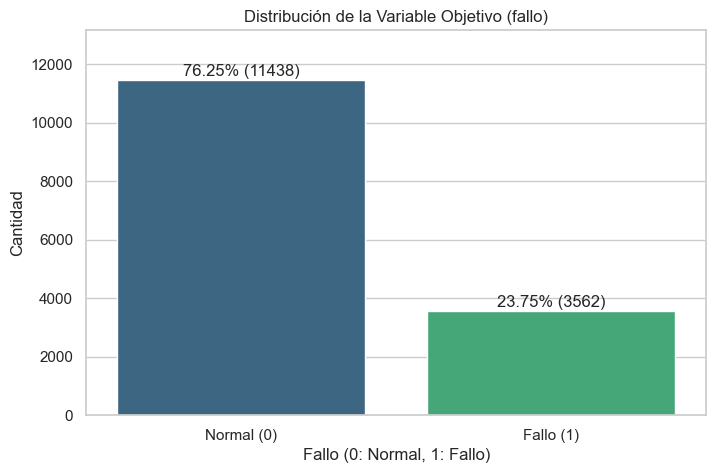

In [5]:
fallo_counts = df_train['fallo'].value_counts()
fallo_perc = df_train['fallo'].value_counts(normalize=True) * 100

print("\nDistribución de la variable 'fallo':")
print(fallo_counts)
print(f"\nPorcentaje:\n{fallo_perc}")

# Visualización
plt.figure(figsize=(8, 5))
sns.countplot(x='fallo', data=df_train, palette='viridis')
plt.title('Distribución de la Variable Objetivo (fallo)')
plt.xlabel('Fallo (0: Normal, 1: Fallo)')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1], labels=['Normal (0)', 'Fallo (1)'])
# Añadir porcentajes en el gráfico
total = len(df_train['fallo'])
for i, count in enumerate(fallo_counts):
    plt.text(i, count + 50, f'{fallo_perc[i]:.2f}% ({count})', ha='center', va='bottom')
plt.ylim(0, max(fallo_counts)*1.15) # Ajustar límite superior para texto
plt.show()


### Análisis Variables Numéricas


Estadísticas descriptivas (df_train):
        temperatura       presion  sensor_ruido      sensor_3
count  15000.000000  14375.000000  15000.000000  15000.000000
mean      15.687367     69.060121      0.000292     15.717596
std        9.315892     15.719516      1.004376     13.593341
min      -14.070606     17.390456     -3.999332    -32.088469
25%        8.801566     58.089213     -0.675742      6.433650
50%       15.680120     69.035402      0.006462     15.615949
75%       22.667966     79.949624      0.659439     24.886303
max       42.445902    129.530558      3.766234     70.445377


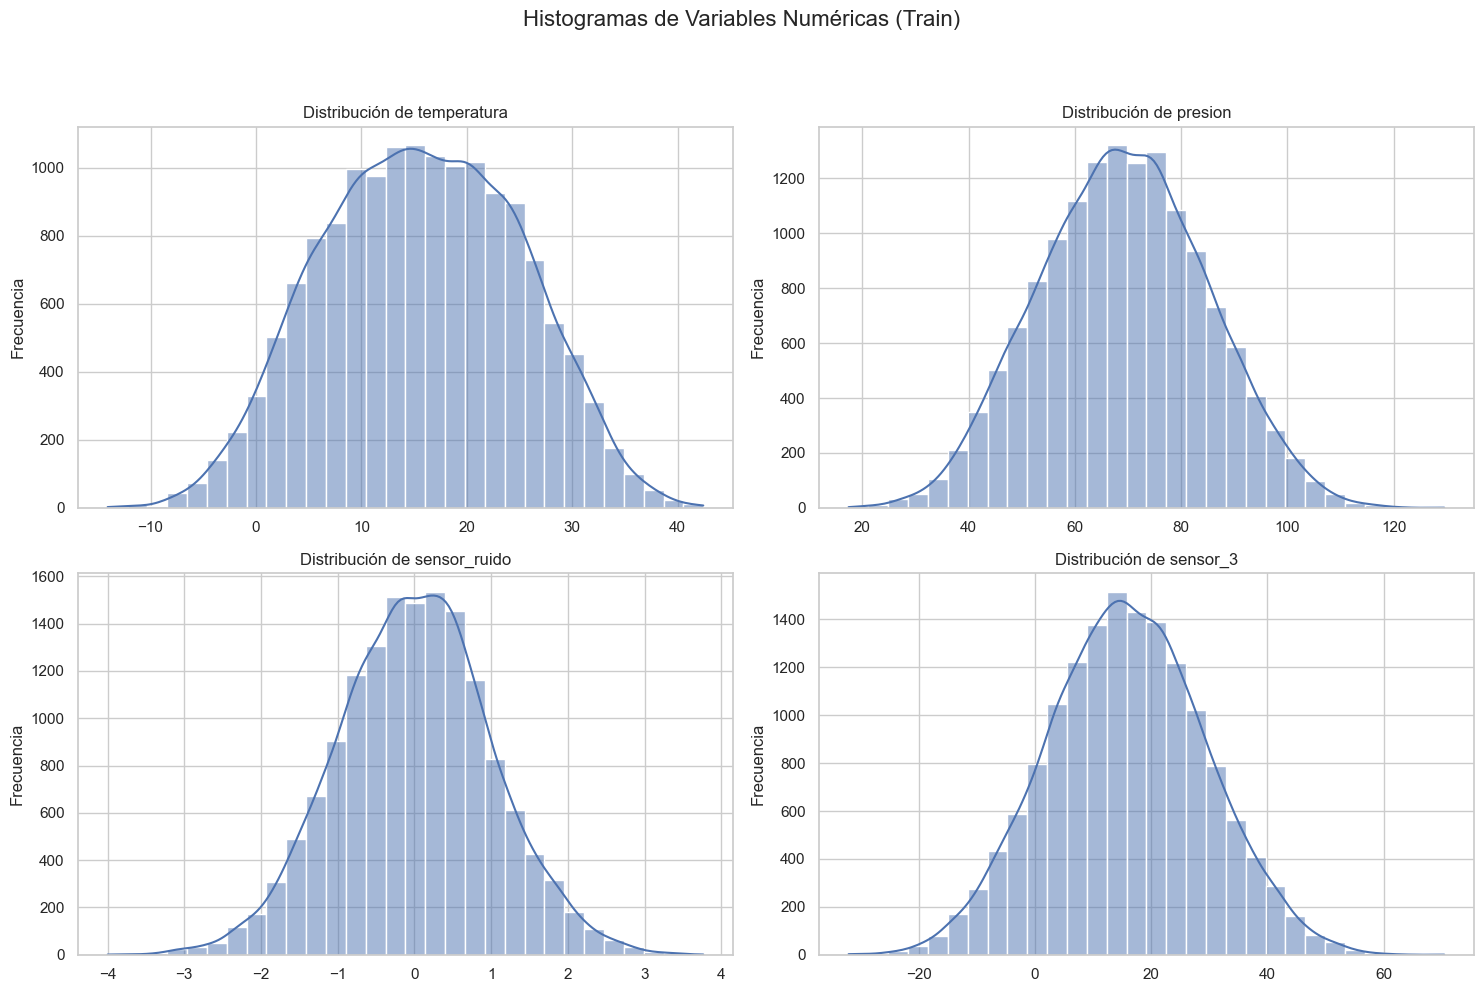

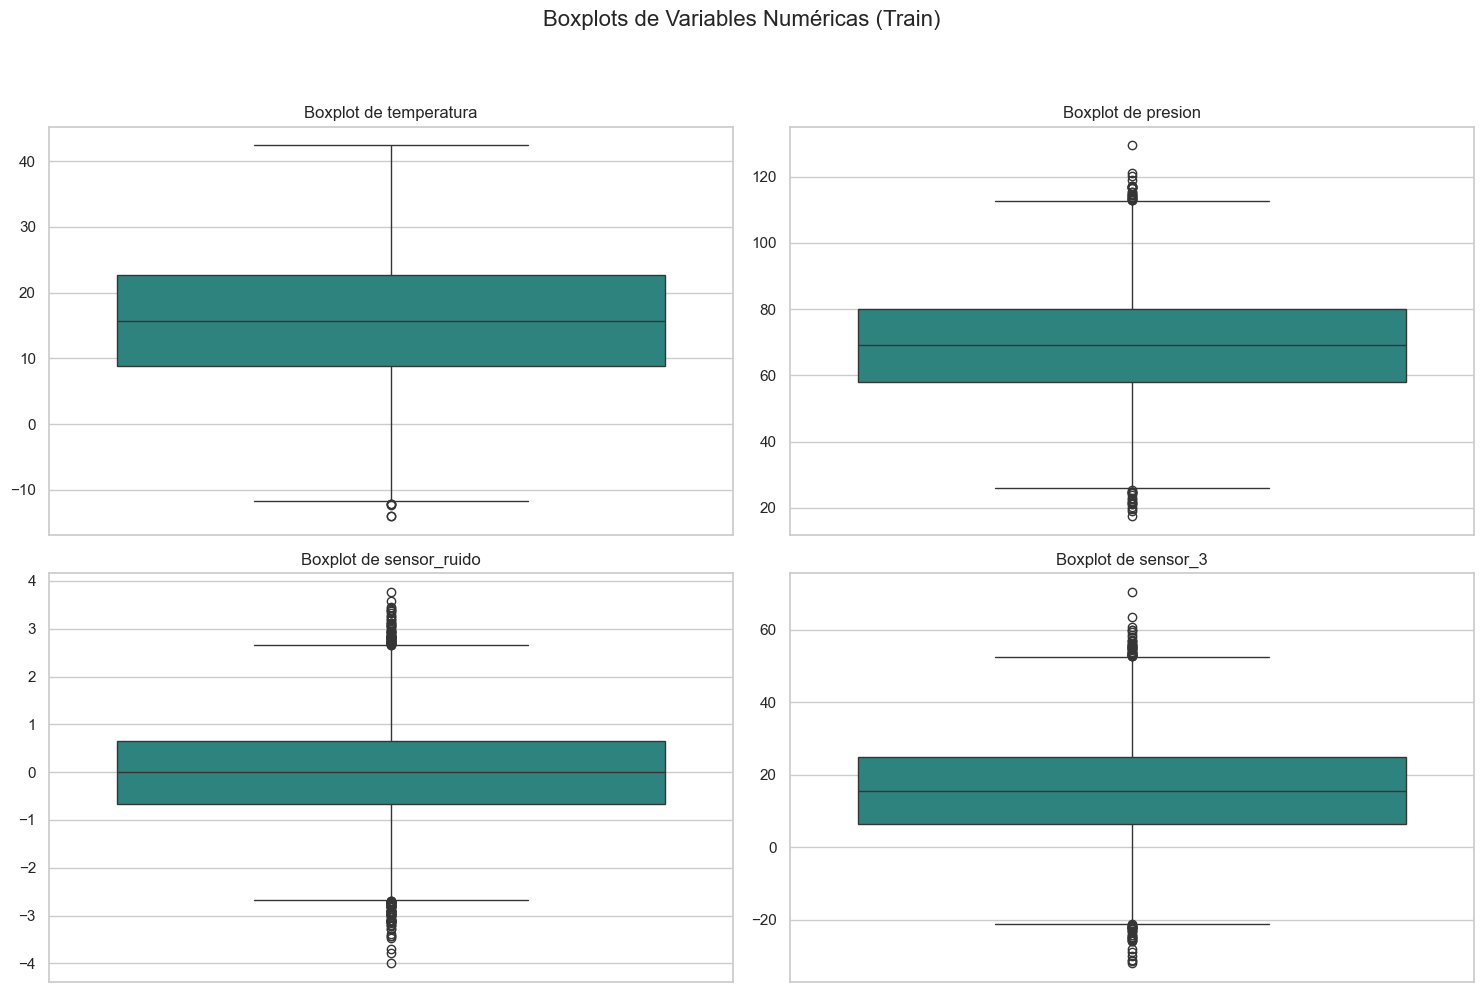

In [6]:
numerical_cols = ['temperatura', 'presion', 'sensor_ruido', 'sensor_3']

print("\nEstadísticas descriptivas (df_train):")
print(df_train[numerical_cols].describe())

n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df_train[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel('') 
    axes[i].set_ylabel('Frecuencia')

if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Histogramas de Variables Numéricas (Train)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.show()


fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df_train[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel('') 


if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Boxplots de Variables Numéricas (Train)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### Análisis Faltantes

Como se ha indicado en el enunciado...

In [7]:
print("\nValores faltantes por columna (df_train):")
missing_train = df_train.isnull().sum()
missing_train_perc = (missing_train / len(df_train)) * 100
missing_train_df = pd.DataFrame({'Count': missing_train, 'Percentage': missing_train_perc})
print(missing_train_df[missing_train_df['Count'] > 0])

print("\nValores faltantes por columna (df_test):")
missing_test = df_test.isnull().sum()
missing_test_perc = (missing_test / len(df_test)) * 100
missing_test_df = pd.DataFrame({'Count': missing_test, 'Percentage': missing_test_perc})
print(missing_test_df[missing_test_df['Count'] > 0]) 



Valores faltantes por columna (df_train):
          Count  Percentage
operador   2731   18.206667
presion     625    4.166667

Valores faltantes por columna (df_test):
          Count  Percentage
operador   2700   18.000000
presion     625    4.166667


### Analisis Específico

#### TimeStamp: hora, dia, mes, año...


Componentes de fecha/hora extraídos en df_train (year, month, day, dayofweek, hour).
Componentes de fecha/hora extraídos en df_test (year, month, day, dayofweek, hour).

Rango de fechas en df_train: 2020-01-01 00:00:00 a 2021-09-16 23:00:00
Rango de fechas en df_test:  2021-09-17 00:00:00 a 2023-06-03 23:00:00


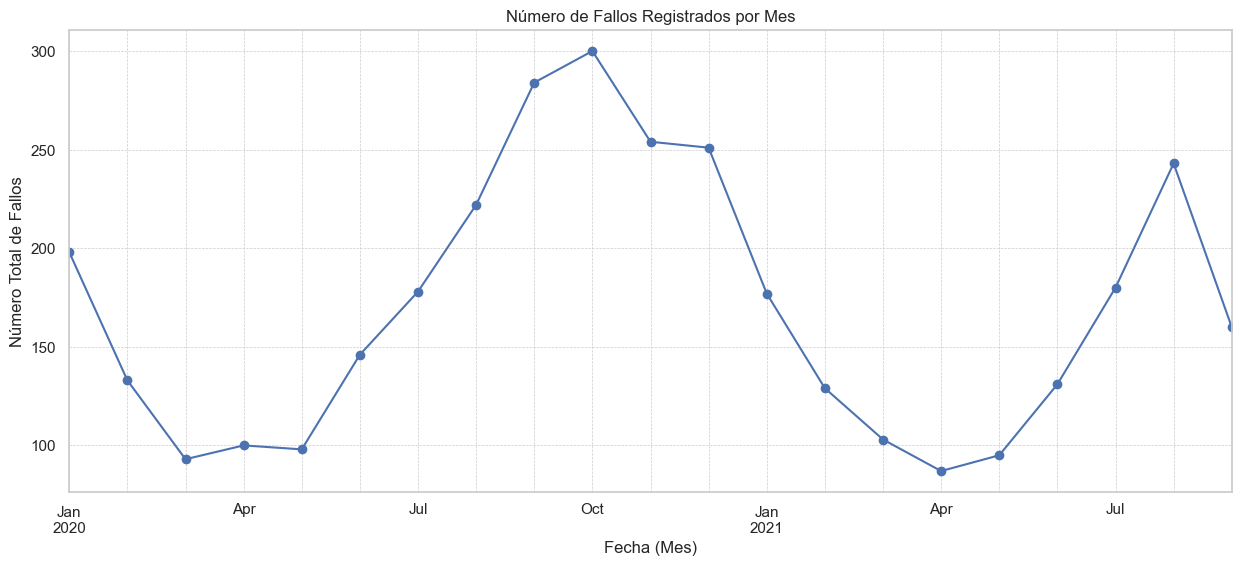

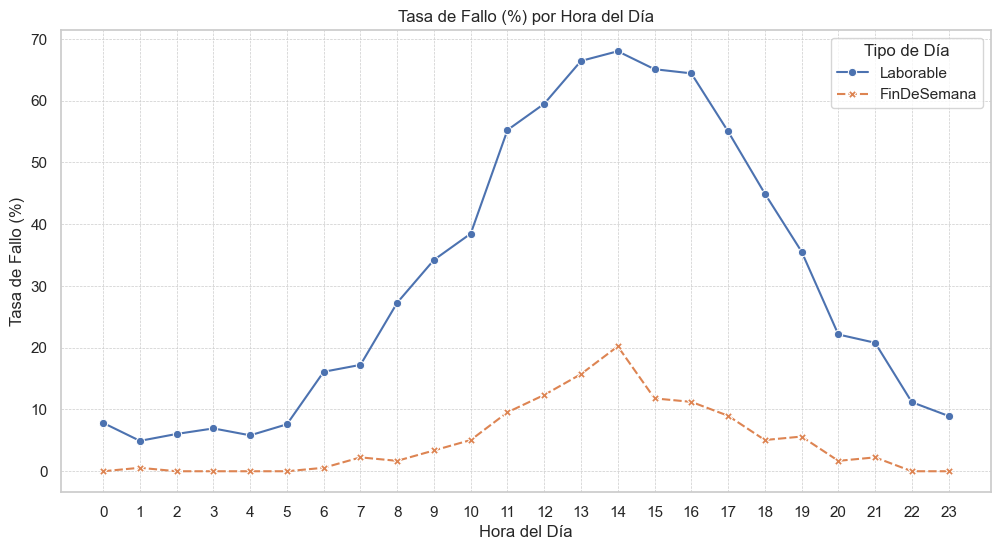

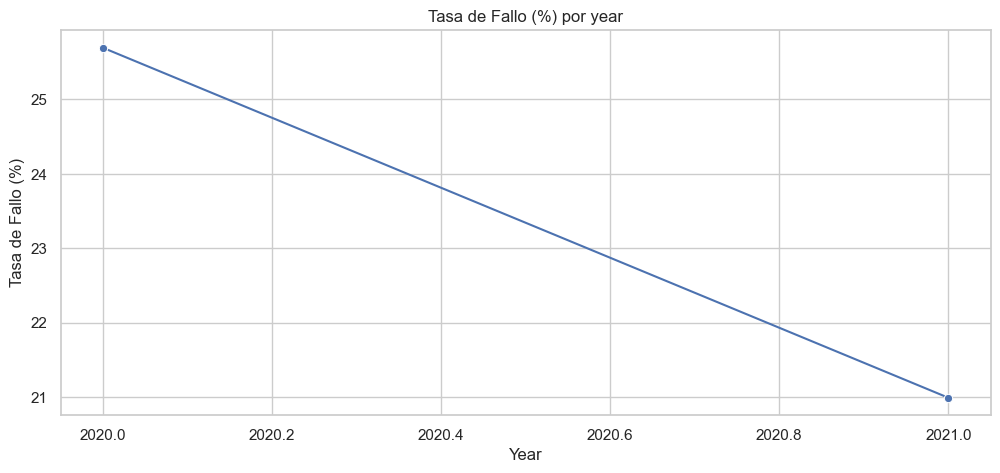

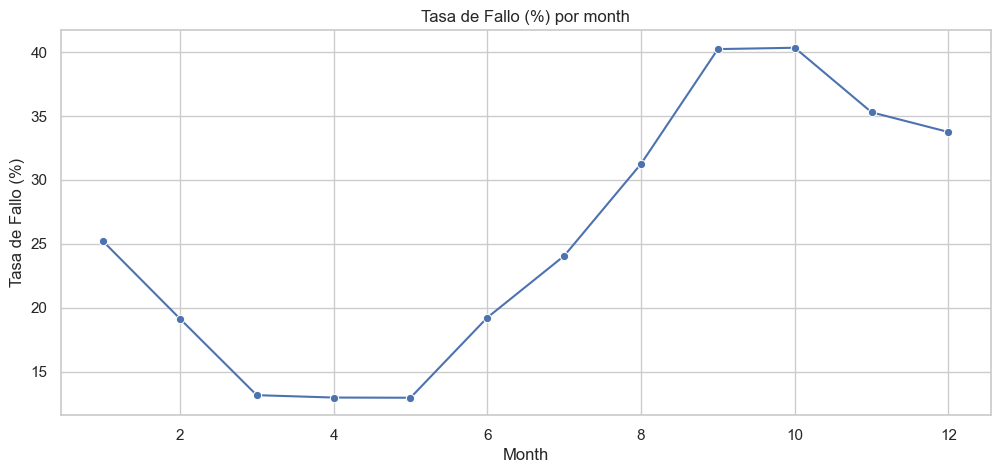

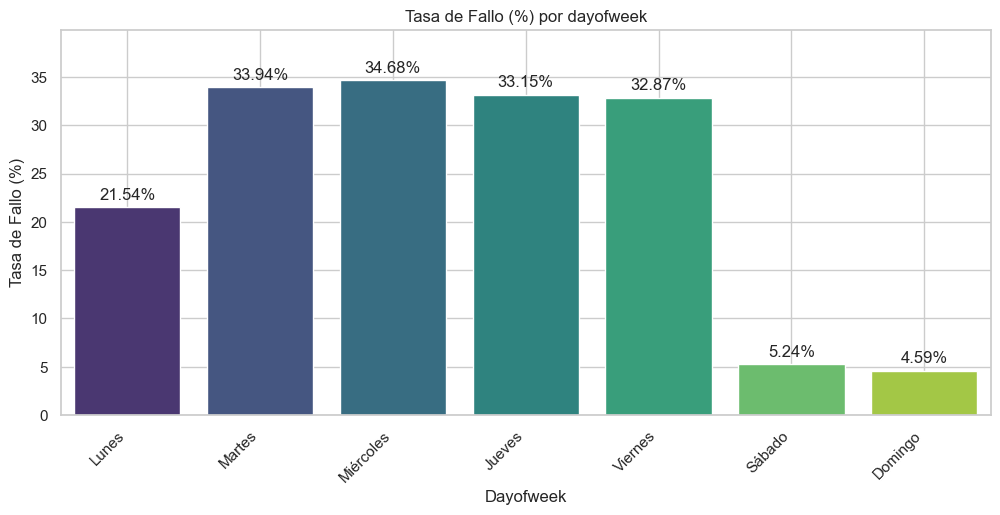

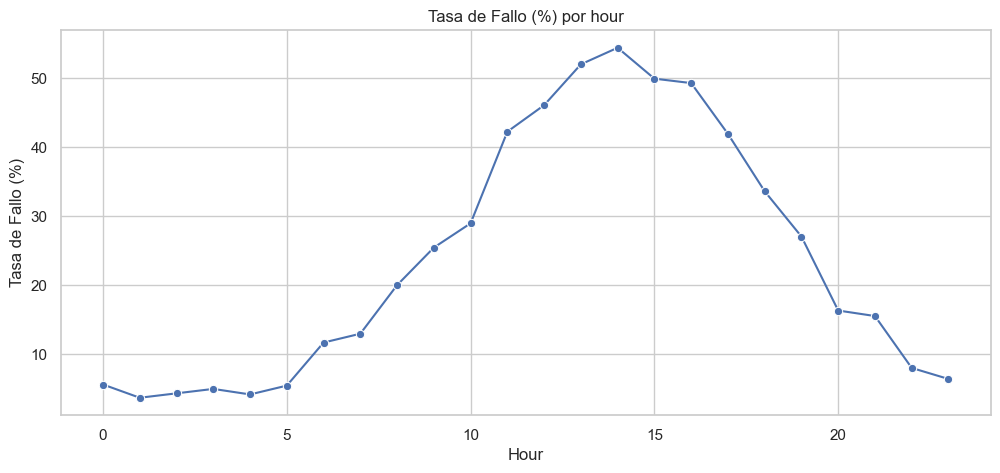

In [8]:
original_missing_train = df_train['timestamp'].isnull().sum()
original_missing_test = df_test['timestamp'].isnull().sum()

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'], errors='coerce')
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'], errors='coerce')

df_train['year'] = df_train['timestamp'].dt.year
df_train['month'] = df_train['timestamp'].dt.month
df_train['day'] = df_train['timestamp'].dt.day
df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek # Lunes=0, Domingo=6
df_train['hour'] = df_train['timestamp'].dt.hour
print("\nComponentes de fecha/hora extraídos en df_train (year, month, day, dayofweek, hour).")

df_test['year'] = df_test['timestamp'].dt.year
df_test['month'] = df_test['timestamp'].dt.month
df_test['day'] = df_test['timestamp'].dt.day
df_test['dayofweek'] = df_test['timestamp'].dt.dayofweek
df_test['hour'] = df_test['timestamp'].dt.hour
print("Componentes de fecha/hora extraídos en df_test (year, month, day, dayofweek, hour).")


print(f"\nRango de fechas en df_train: {df_train['timestamp'].min()} a {df_train['timestamp'].max()}")
print(f"Rango de fechas en df_test:  {df_test['timestamp'].min()} a {df_test['timestamp'].max()}")


df_train_sorted = df_train.sort_values('timestamp').copy()
df_train_sorted['YearMonth'] = df_train_sorted['timestamp'].dt.to_period('M')
fallos_por_mes = df_train_sorted.groupby('YearMonth')['fallo'].sum()

fallos_por_mes.index = fallos_por_mes.index.to_timestamp()

plt.figure(figsize=(15, 6))
fallos_por_mes.plot(kind='line', marker='o', linestyle='-')
plt.title('Número de Fallos Registrados por Mes')
plt.xlabel('Fecha (Mes)')
plt.ylabel('Número Total de Fallos')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



df_train['EsFinDeSemana'] = df_train['dayofweek'].isin([5, 6]) 
failure_rate_hourly_weekday = df_train.groupby(['EsFinDeSemana', 'hour'])['fallo'].mean().unstack(level=0) * 100
failure_rate_hourly_weekday.columns = ['Laborable', 'FinDeSemana'] 

plt.figure(figsize=(12, 6))
sns.lineplot(data=failure_rate_hourly_weekday, markers=True)
plt.title('Tasa de Fallo (%) por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Tasa de Fallo (%)')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Tipo de Día')
plt.show()


#Dia de la semana...
time_cols = ['year', 'month', 'dayofweek', 'hour']
time_cols = [col for col in time_cols if col in df_train.columns]
for col in time_cols:
    failure_rate_time = df_train.groupby(col)['fallo'].mean().sort_index() * 100

    plt.figure(figsize=(12, 5))
    if col in ['month', 'hour', 'year']:
            sns.lineplot(x=failure_rate_time.index, y=failure_rate_time.values, marker='o')
            plt.ylabel('Tasa de Fallo (%)')
    elif col == 'dayofweek':
        day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
        sns.barplot(x=failure_rate_time.index, y=failure_rate_time.values, palette='viridis')
        plt.xticks(ticks=range(7), labels=day_names, rotation=45, ha='right')
        plt.ylabel('Tasa de Fallo (%)')
        for index, value in enumerate(failure_rate_time.values):
            plt.text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')
        plt.ylim(0, max(failure_rate_time.values)*1.15)

    plt.title(f'Tasa de Fallo (%) por {col}')
    plt.xlabel(col.capitalize()) 
    plt.grid(True)
    plt.show()


#### Relaciones entre variables

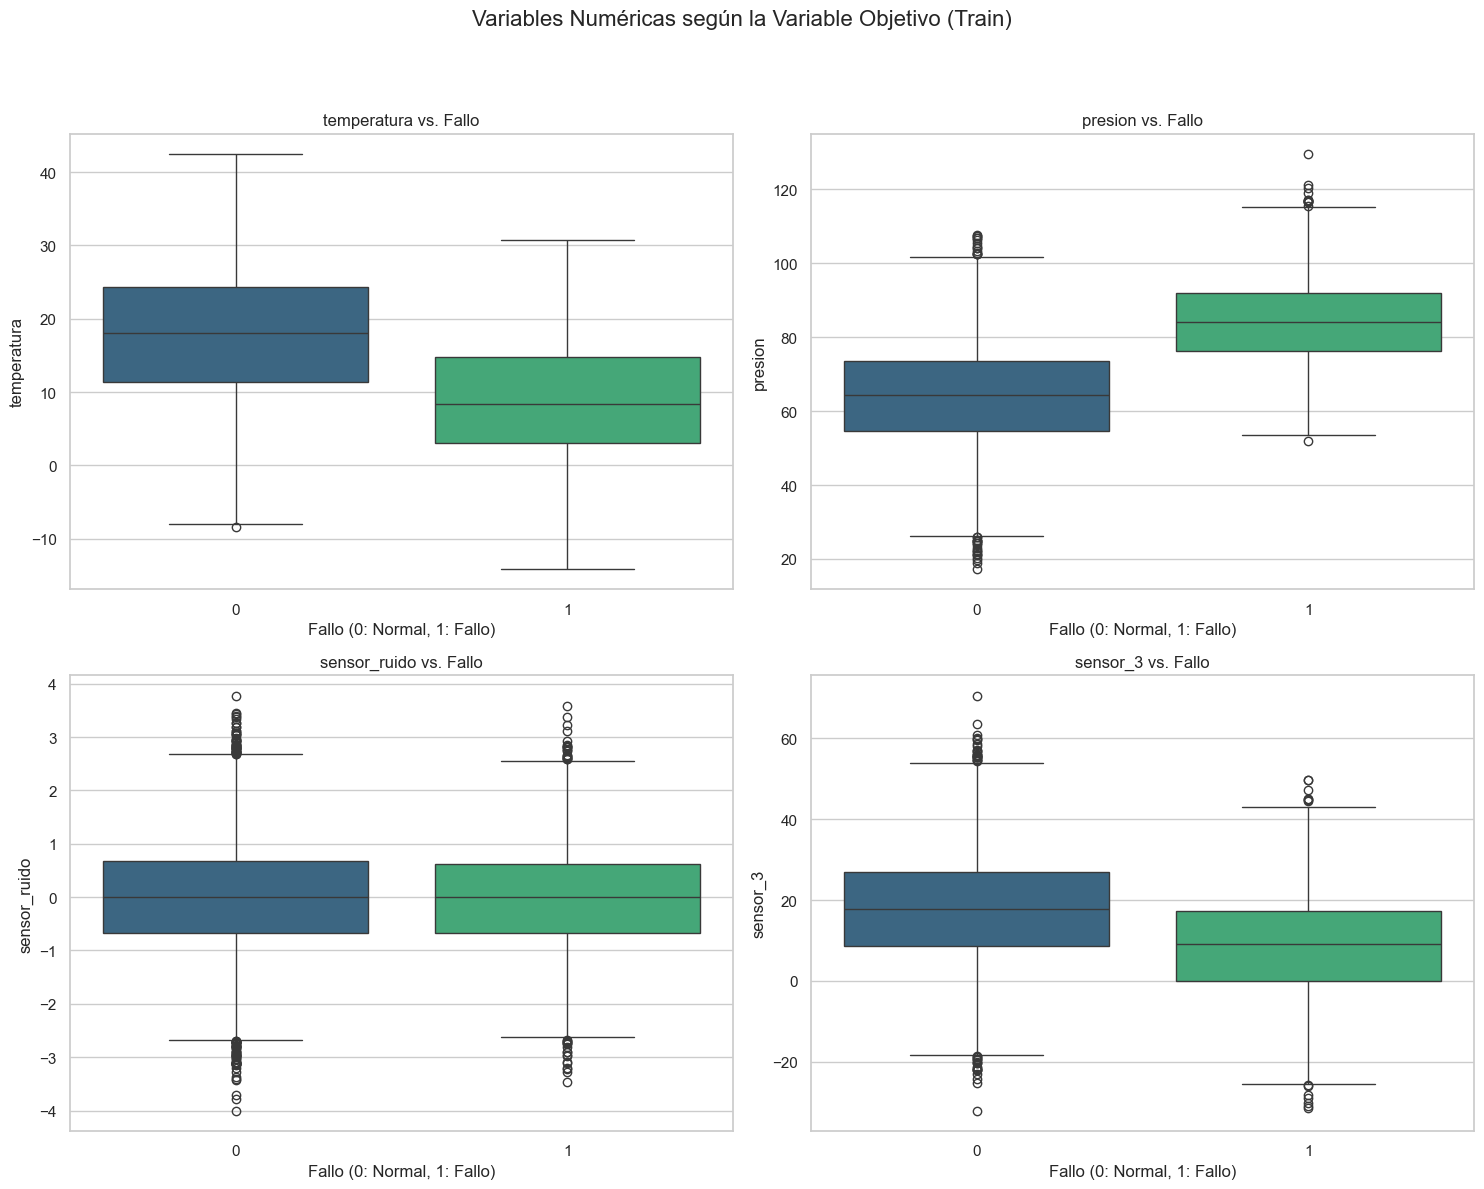

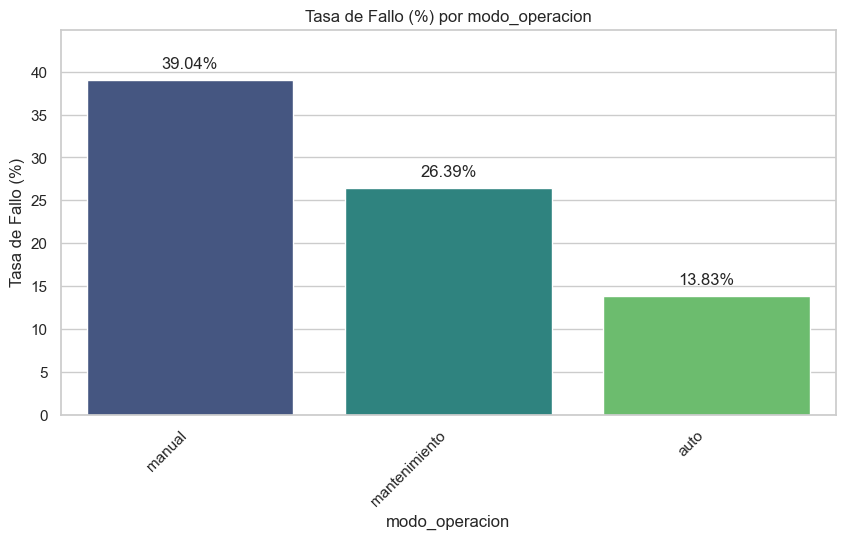

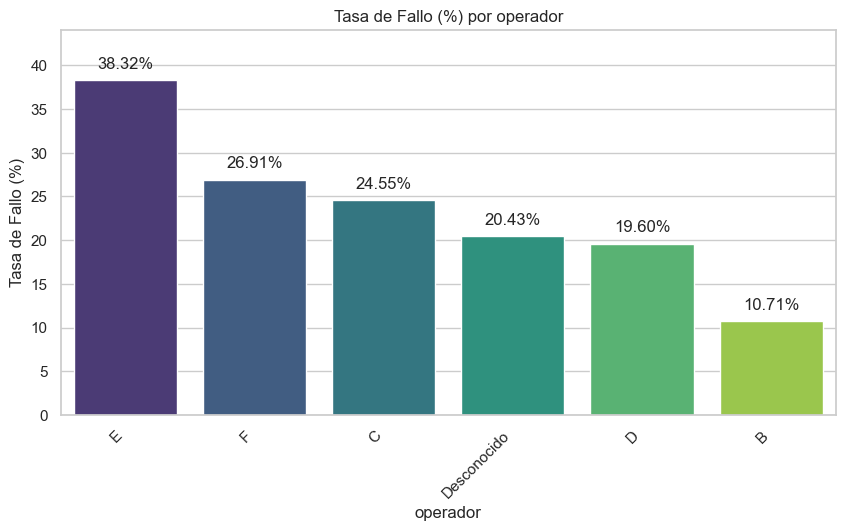

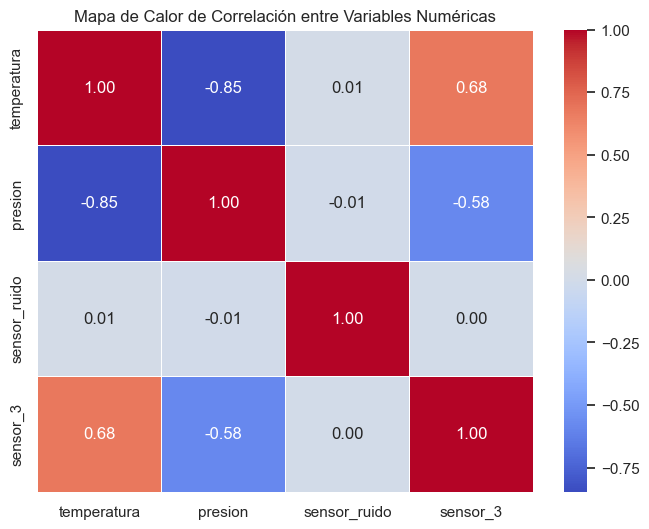

In [9]:
# Relaciones entre Numéricas
numerical_cols = ['temperatura', 'presion', 'sensor_ruido', 'sensor_3']

n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 6)) # Aumentamos un poco el tamaño vertical
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='fallo', y=col, data=df_train, ax=axes[i], palette='viridis', showfliers=True) 
    axes[i].set_title(f'{col} vs. Fallo')
    axes[i].set_xlabel('Fallo (0: Normal, 1: Fallo)')
    axes[i].set_ylabel(col)

if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Variables Numéricas según la Variable Objetivo (Train)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()



# Relaciones entre Categóricas
categorical_cols = ['modo_operacion', 'operador']
df_train_temp = df_train.copy()
df_train_temp['operador'] = df_train_temp['operador'].fillna('Desconocido')

for col in categorical_cols:
    failure_rate = df_train_temp.groupby(col)['fallo'].mean().sort_values(ascending=False) * 100

    plt.figure(figsize=(10, 5))

    sns.barplot(x=failure_rate.index, y=failure_rate.values, palette='viridis', order=failure_rate.index)
    plt.title(f'Tasa de Fallo (%) por {col}')
    plt.xlabel(col)
    plt.ylabel('Tasa de Fallo (%)')
    plt.xticks(rotation=45, ha='right')

    for index, value in enumerate(failure_rate.values):
        plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom')
    plt.ylim(0, max(failure_rate.values)*1.15) 
    plt.show()

del df_train_temp

correlation_matrix = df_train[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlación entre Variables Numéricas')
plt.show()

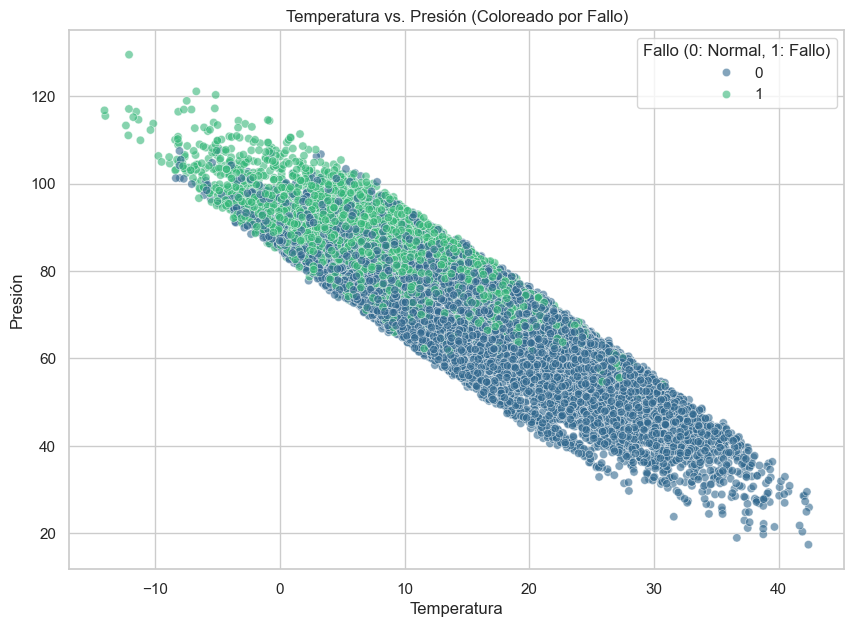

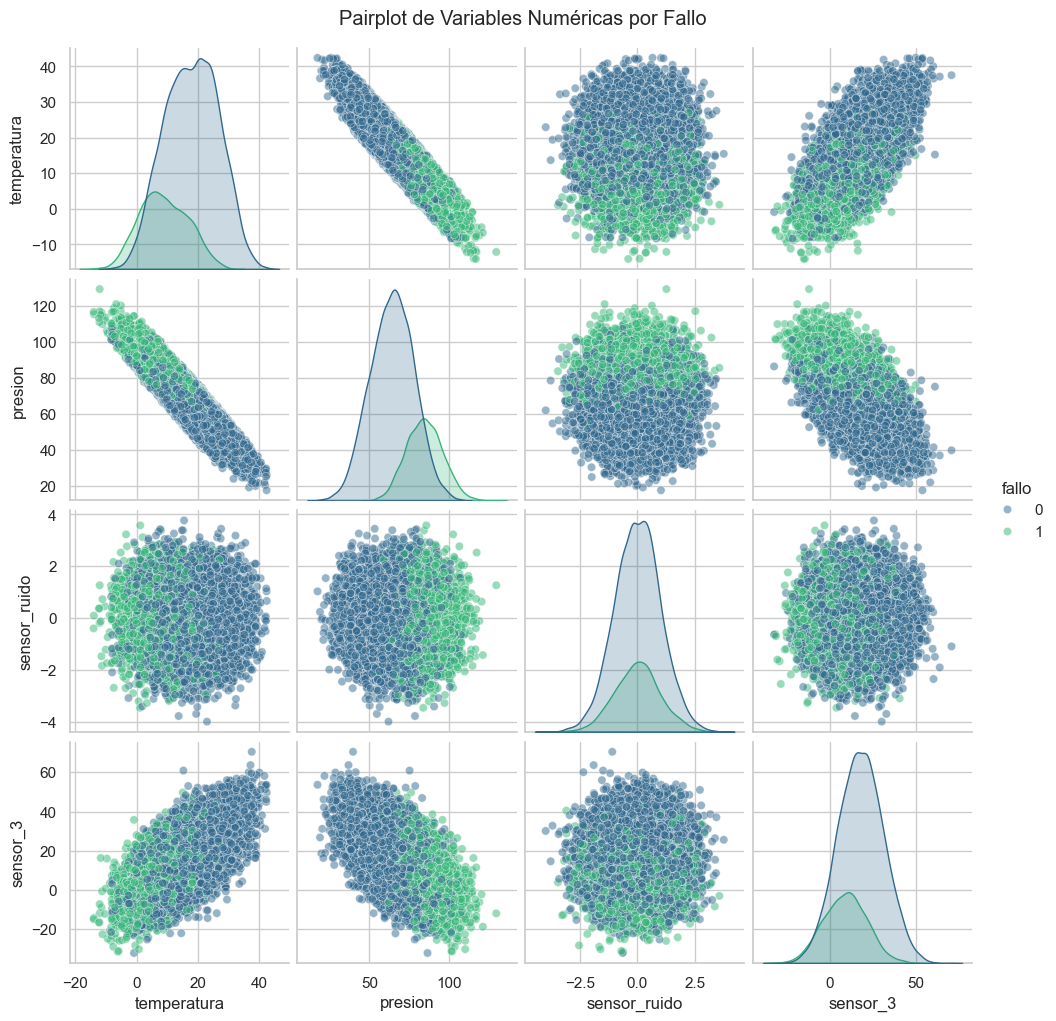

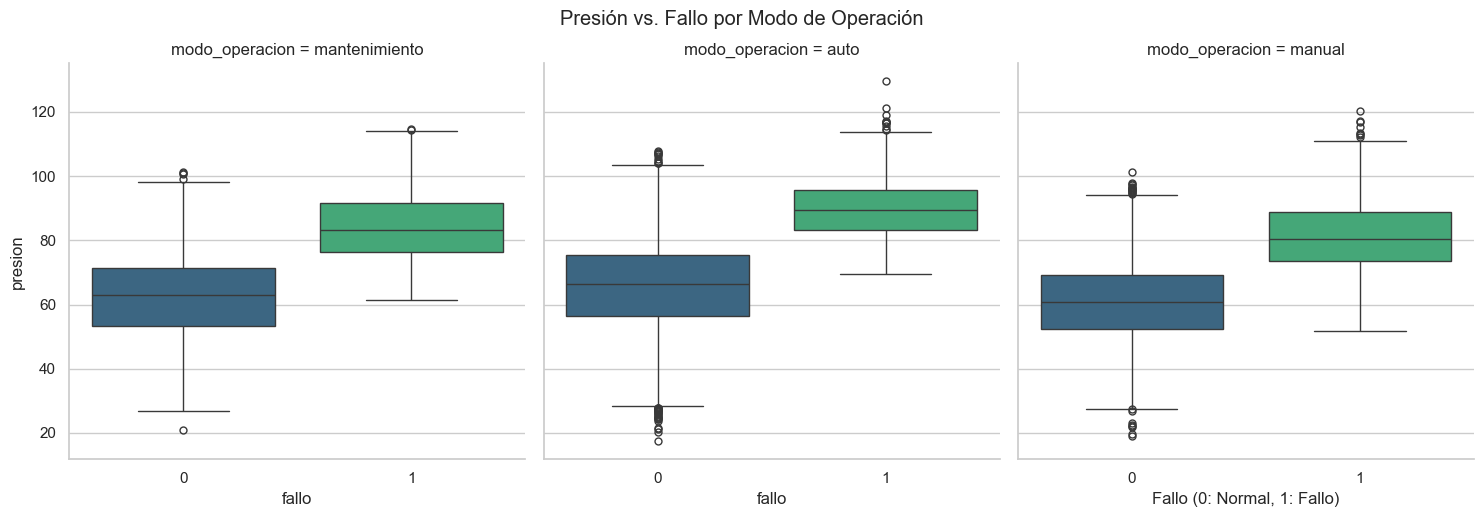

In [10]:

df_train_filled = df_train.copy()
df_train_filled['operador'] = df_train_filled['operador'].fillna('Desconocido')
df_test_filled = df_test.copy() # Hacemos lo mismo en test para comparaciones
df_test_filled['operador'] = df_test_filled['operador'].fillna('Desconocido')


numerical_cols = ['temperatura', 'presion', 'sensor_ruido', 'sensor_3']
categorical_cols = ['modo_operacion', 'operador'] 
time_cols = ['year', 'month', 'dayofweek', 'hour']


plt.figure(figsize=(10, 7))
sns.scatterplot(x='temperatura', y='presion', data=df_train, hue='fallo', palette='viridis', alpha=0.6)
plt.title('Temperatura vs. Presión (Coloreado por Fallo)')
plt.xlabel('Temperatura')
plt.ylabel('Presión')
plt.legend(title='Fallo (0: Normal, 1: Fallo)')
plt.show()



sns.pairplot(df_train, vars=numerical_cols, hue='fallo', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot de Variables Numéricas por Fallo', y=1.02)
plt.show()



sns.catplot(x='fallo', y='presion', col='modo_operacion', data=df_train, kind='box', palette='viridis', showfliers=True)
plt.suptitle('Presión vs. Fallo por Modo de Operación', y=1.03)
plt.xlabel('Fallo (0: Normal, 1: Fallo)') # Ajustar etiqueta eje X global
plt.show()

#### Comparación Train y Test

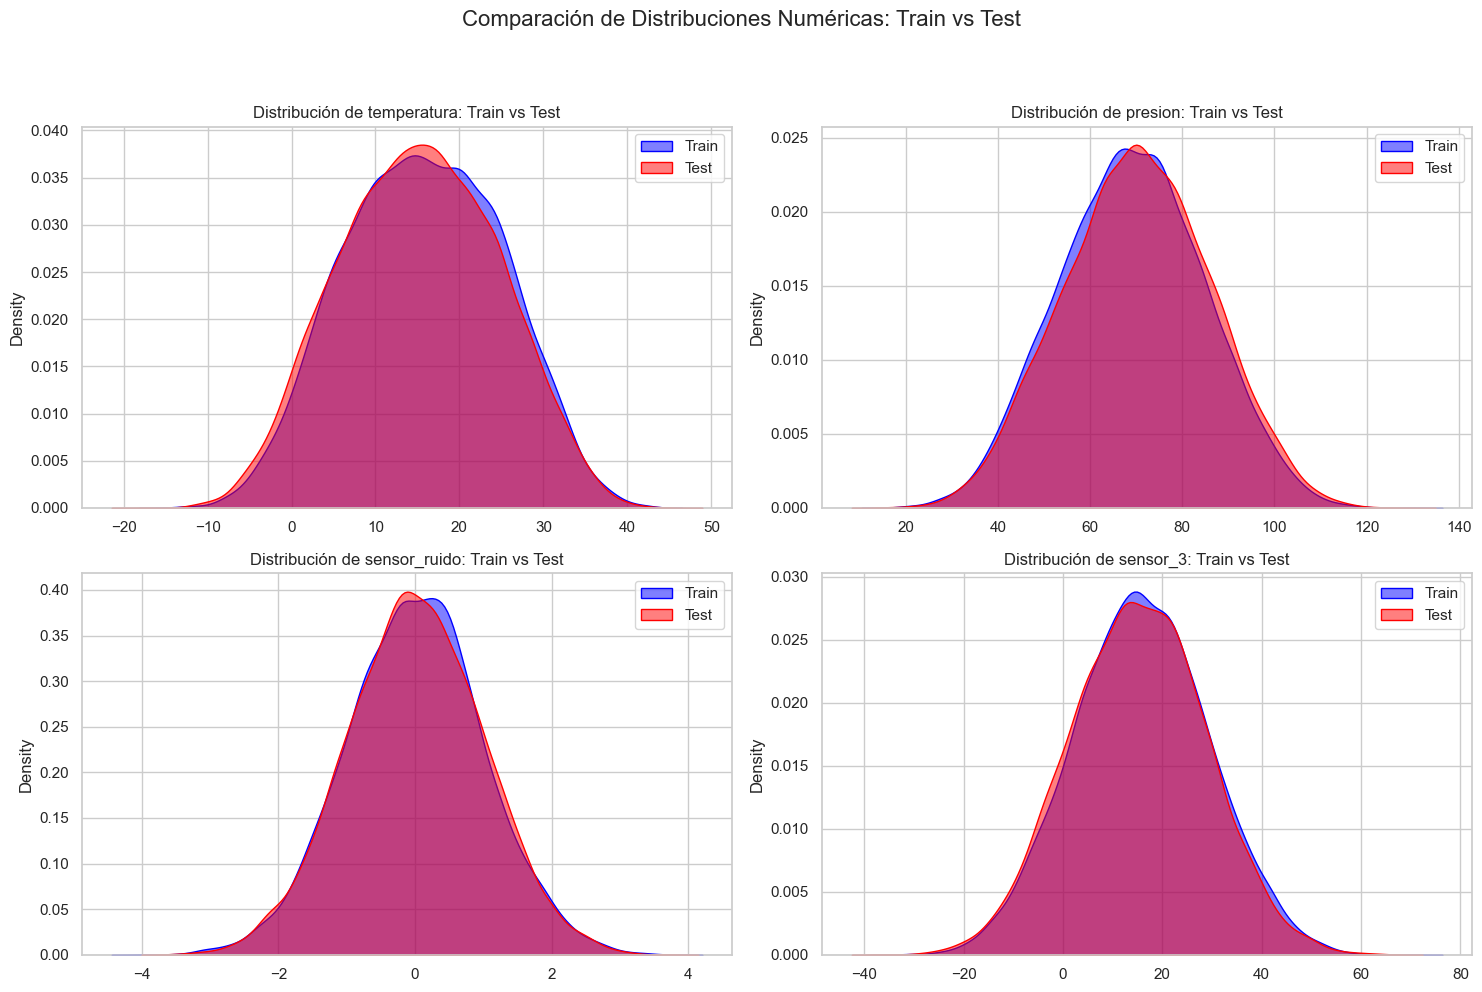

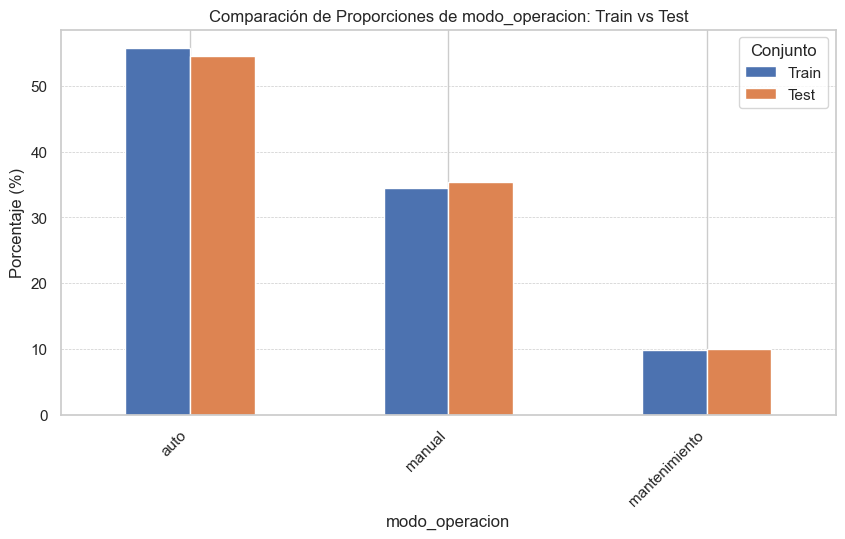

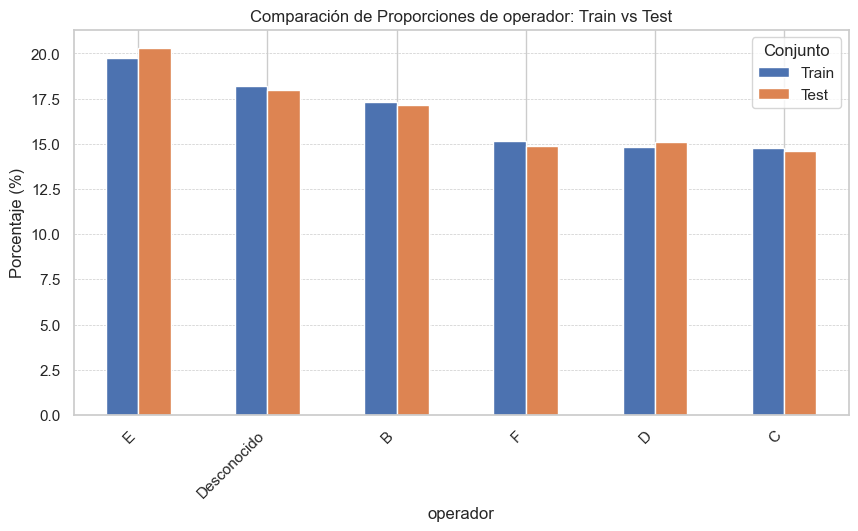

In [11]:
n_cols_plot = 2
n_rows_plot = (len(numerical_cols) + n_cols_plot - 1) // n_cols_plot
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, n_rows_plot * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(df_train[col], ax=axes[i], label='Train', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(df_test[col], ax=axes[i], label='Test', color='red', fill=True, alpha=0.5)
    axes[i].set_title(f'Distribución de {col}: Train vs Test')
    axes[i].set_xlabel('')
    axes[i].legend()

if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Comparación de Distribuciones Numéricas: Train vs Test', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

for col in categorical_cols:
    train_counts = df_train_filled[col].value_counts(normalize=True).rename('Train')
    test_counts = df_test_filled[col].value_counts(normalize=True).rename('Test')

    df_compare = pd.concat([train_counts, test_counts], axis=1).fillna(0) * 100 # En porcentaje

    df_compare.plot(kind='bar', figsize=(10, 5))
    plt.title(f'Comparación de Proporciones de {col}: Train vs Test')
    plt.ylabel('Porcentaje (%)')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Conjunto')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()


### Principales descubrimientos

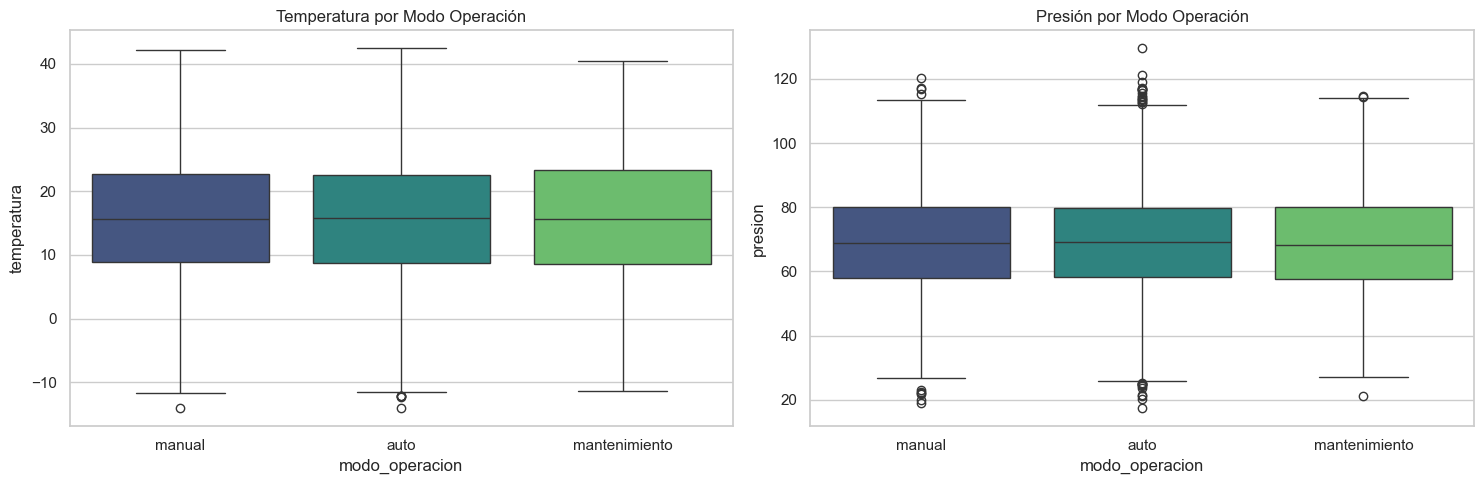

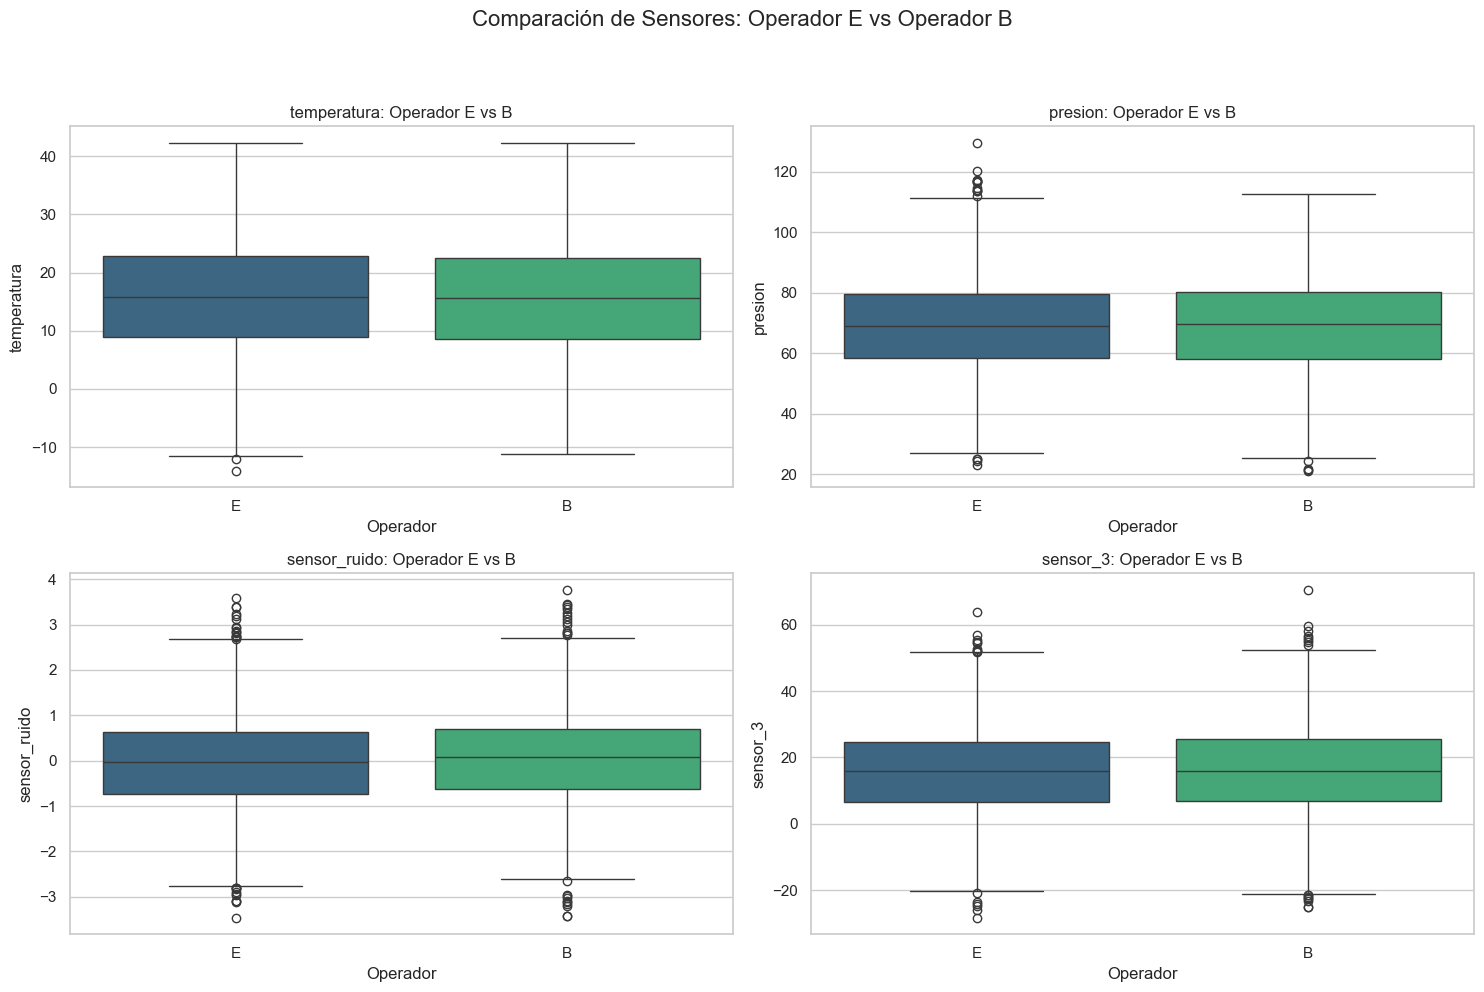

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='modo_operacion', y='temperatura', data=df_train, palette='viridis', order=['manual','auto','mantenimiento'])
plt.title('Temperatura por Modo Operación')
plt.subplot(1, 2, 2)
sns.boxplot(x='modo_operacion', y='presion', data=df_train, palette='viridis', order=['manual','auto','mantenimiento'])
plt.title('Presión por Modo Operación')
plt.tight_layout()
plt.show()

df_operador_compare = df_train_filled[df_train_filled['operador'].isin(['E', 'B'])]

n_cols_plot = 2
n_rows_plot = (len(numerical_cols) + n_cols_plot - 1) // n_cols_plot
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, n_rows_plot * 5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='operador', y=col, data=df_operador_compare, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{col}: Operador E vs B')
    axes[i].set_xlabel('Operador')
    axes[i].set_ylabel(col)

if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Comparación de Sensores: Operador E vs Operador B', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

del df_train_filled
del df_test_filled
del df_train_sorted


---

# 3. Preprocesamiento

In [120]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce 
import itertools 
import warnings

# Ignorar warnings para mantener la salida limpia
warnings.filterwarnings('ignore')

# Cargar datos
try:
    df_entrenamiento_bruto = pd.read_csv('train.csv')
    df_prueba_bruto = pd.read_csv('test.csv')
    print("Datos cargados correctamente.")
    print("\nPrimeras 5 filas de df_entrenamiento_bruto:")
    print(df_entrenamiento_bruto.head())
except FileNotFoundError:
    print("ERROR: Asegúrate de que 'train.csv' y 'test.csv' estén en el directorio correcto.")
    df_entrenamiento_bruto = pd.DataFrame() 
    df_prueba_bruto = pd.DataFrame()

Datos cargados correctamente.

Primeras 5 filas de df_entrenamiento_bruto:
      id            timestamp modo_operacion operador  temperatura    presion  \
0  15000  2021-04-24 03:00:00  mantenimiento      NaN    20.428941  58.474497   
1  15001  2020-09-26 19:00:00  mantenimiento        E     1.332931  84.784184   
2  15002  2021-07-02 15:00:00           auto        D    17.501579  65.057682   
3  15003  2020-02-05 22:00:00           auto      NaN     8.118801  70.127615   
4  15004  2020-09-05 18:00:00         manual      NaN    -0.353122  90.738090   

   sensor_ruido   sensor_3  fallo  
0      0.349400  18.301299      0  
1     -2.252684   7.295245      0  
2      0.359853  34.271305      0  
3      0.489166  -3.748938      0  
4     -1.505866  10.157637      0  


In [121]:
objetivo = 'fallo'

columnas_numericas_base = ['temperatura', 'presion', 'sensor_ruido', 'sensor_3']
columnas_categoricas = ['modo_operacion', 'operador'] 
columna_id = 'id' # Estan aparte para poder tratarlas ahora
columna_timestamp = 'timestamp'


# Mostrar NaNs
print("\nNaNs en df_entrenamiento_bruto:")
print(df_entrenamiento_bruto.isnull().sum())
print("\nNaNs en df_prueba_bruto:")
print(df_prueba_bruto.isnull().sum())


NaNs en df_entrenamiento_bruto:
id                   0
timestamp            0
modo_operacion       0
operador          2731
temperatura          0
presion            625
sensor_ruido         0
sensor_3             0
fallo                0
dtype: int64

NaNs en df_prueba_bruto:
id                   0
timestamp            0
modo_operacion       0
operador          2700
temperatura          0
presion            625
sensor_ruido         0
sensor_3             0
dtype: int64


# Preparamos Datos

## Columnas id y TimeStamp

In [122]:
# Crear copias de trabajo
df_entrenamiento = df_entrenamiento_bruto.copy()
df_prueba = df_prueba_bruto.copy()

print(f"  Eliminando '{columna_id}' de df_entrenamiento.")
df_entrenamiento = df_entrenamiento.drop(columns=[columna_id])
print(f"  Eliminando '{columna_id}' de df_prueba.")
df_prueba = df_prueba.drop(columns=[columna_id])


def dividirTimeStamp(df, nombre_columna):    
    df[nombre_columna] = pd.to_datetime(df[nombre_columna])

    df['hora'] = df[nombre_columna].dt.hour
    df['dia_semana'] = df[nombre_columna].dt.dayofweek # Lunes=0, Domingo=6
    df['mes'] = df[nombre_columna].dt.month
    df['dia_del_anio'] = df[nombre_columna].dt.dayofyear
    df['es_fin_de_semana'] = (df[nombre_columna].dt.dayofweek >= 5).astype(int) 
    
    caracteristicas_generadas = ['hora', 'dia_semana', 'mes', 'dia_del_anio', 'es_fin_de_semana']
    
    # Se elimina la columna del df original
    df = df.drop(columns=[nombre_columna])
    return df, caracteristicas_generadas

df_entrenamiento, caracteristicas_tiempo_generadas_train = dividirTimeStamp(df_entrenamiento, columna_timestamp)
df_prueba, _ = dividirTimeStamp(df_prueba, columna_timestamp) # No necesitamos la lista de test, asumimos que es la misma

todas_columnas_numericas = columnas_numericas_base + caracteristicas_tiempo_generadas_train

print(f"\nNuevas características de tiempo generadas: {caracteristicas_tiempo_generadas_train}")
print(f"Todas las características numéricas para imputación serán: {todas_columnas_numericas}")
print(df_entrenamiento.head())


  Eliminando 'id' de df_entrenamiento.
  Eliminando 'id' de df_prueba.

Nuevas características de tiempo generadas: ['hora', 'dia_semana', 'mes', 'dia_del_anio', 'es_fin_de_semana']
Todas las características numéricas para imputación serán: ['temperatura', 'presion', 'sensor_ruido', 'sensor_3', 'hora', 'dia_semana', 'mes', 'dia_del_anio', 'es_fin_de_semana']
  modo_operacion operador  temperatura    presion  sensor_ruido   sensor_3  \
0  mantenimiento      NaN    20.428941  58.474497      0.349400  18.301299   
1  mantenimiento        E     1.332931  84.784184     -2.252684   7.295245   
2           auto        D    17.501579  65.057682      0.359853  34.271305   
3           auto      NaN     8.118801  70.127615      0.489166  -3.748938   
4         manual      NaN    -0.353122  90.738090     -1.505866  10.157637   

   fallo  hora  dia_semana  mes  dia_del_anio  es_fin_de_semana  
0      0     3           5    4           114                 1  
1      0    19           5    9       

## Quitar los Nan

### En las Numericas
Hay dos opciones: 

Imputar con la Mediana, se entrena a un modelo y se sustituye los Nan con la prediccion. Es buena pero no siempre fiable

Imputar con KNNImputer, una version mas avanzada de imputar con la mediana. El problema es que hay que escalar los datos antes de pasarlos por el Imputer

In [123]:
df_entrenamiento_procesado = df_entrenamiento.copy()
df_prueba_procesado = df_prueba.copy()

# Columnas numéricas existentes en los dataframes para imputar
columnas_numericas_a_imputar_train = [col for col in todas_columnas_numericas if col in df_entrenamiento_procesado.columns]
columnas_numericas_a_imputar_test = [col for col in todas_columnas_numericas if col in df_prueba_procesado.columns]

In [124]:
# Imputacion de la mediana ==> Peor || Comentado para que no ejecute
"""
imputador_mediana = SimpleImputer(strategy='median')
df_entrenamiento_procesado[columnas_numericas_a_imputar_train] = imputador_mediana.fit_transform(df_entrenamiento_procesado[columnas_numericas_a_imputar_train])

cols_comunes_test = [col for col in columnas_numericas_a_imputar_test if col in imputador_mediana.feature_names_in_]
df_prueba_procesado[cols_comunes_test] = imputador_mediana.transform(df_prueba_procesado[cols_comunes_test])
"""

"\nimputador_mediana = SimpleImputer(strategy='median')\ndf_entrenamiento_procesado[columnas_numericas_a_imputar_train] = imputador_mediana.fit_transform(df_entrenamiento_procesado[columnas_numericas_a_imputar_train])\n\ncols_comunes_test = [col for col in columnas_numericas_a_imputar_test if col in imputador_mediana.feature_names_in_]\ndf_prueba_procesado[cols_comunes_test] = imputador_mediana.transform(df_prueba_procesado[cols_comunes_test])\n"

In [125]:
# KNNImputer ==> La que mejor va
escalador_knn = StandardScaler() 

# Para poder usar KNNImputer, hace falta escalar los datos
df_entrenamiento_escalado_num = escalador_knn.fit_transform(df_entrenamiento_procesado[columnas_numericas_a_imputar_train])

imputador_knn = KNNImputer(n_neighbors=5) 
df_entrenamiento_imputado_escalado = imputador_knn.fit_transform(df_entrenamiento_escalado_num) # Fit y transform en train escalado

# Desescalar train
df_entrenamiento_procesado[columnas_numericas_a_imputar_train] = escalador_knn.inverse_transform(df_entrenamiento_imputado_escalado)

# Transformar test
cols_comunes_test_knn = [col for col in columnas_numericas_a_imputar_test if col in escalador_knn.feature_names_in_]
df_prueba_escalado_num = escalador_knn.transform(df_prueba_procesado[cols_comunes_test_knn])
df_prueba_imputado_escalado = imputador_knn.transform(df_prueba_escalado_num) # Solo transform en test escalado
df_prueba_procesado[cols_comunes_test_knn] = escalador_knn.inverse_transform(df_prueba_imputado_escalado)

### En las categóricas
Aqui simplemente reemplazamos los Nan por un nuevo valor llamado "Desconocido"

In [126]:
columnas_categoricas_a_imputar_train = [col for col in columnas_categoricas if col in df_entrenamiento_procesado.columns]
columnas_categoricas_a_imputar_test = [col for col in columnas_categoricas if col in df_prueba_procesado.columns]

imputador_constante_cat = SimpleImputer(strategy='constant', fill_value='Faltante') # Traducido "Missing"

# Ajustar y transformar train
df_entrenamiento_procesado[columnas_categoricas_a_imputar_train] = imputador_constante_cat.fit_transform(df_entrenamiento_procesado[columnas_categoricas_a_imputar_train])

# Transformar test
cols_comunes_test_cat = [col for col in columnas_categoricas_a_imputar_test if col in imputador_constante_cat.feature_names_in_]
df_prueba_procesado[cols_comunes_test_cat] = imputador_constante_cat.transform(df_prueba_procesado[cols_comunes_test_cat])

### Comprobacion de los Nans

In [127]:
print("\nComprobación de NaNs después de toda la imputación:")
print("NaNs en df_entrenamiento_procesado (solo columnas con NaNs):")
print(df_entrenamiento_procesado.isnull().sum().loc[lambda x: x > 0])
print("\nNaNs en df_prueba_procesado (solo columnas con NaNs):")
print(df_prueba_procesado.isnull().sum().loc[lambda x: x > 0])


Comprobación de NaNs después de toda la imputación:
NaNs en df_entrenamiento_procesado (solo columnas con NaNs):
Series([], dtype: int64)

NaNs en df_prueba_procesado (solo columnas con NaNs):
Series([], dtype: int64)


## Tratar las categoricas para los modelos
Vamos a probar dos, OneHot y Target Encoding.

In [128]:
# df_entrenamiento_final y df_prueba_final serán el resultado de esta celda
df_entrenamiento_final = df_entrenamiento_procesado.copy()
df_prueba_final = df_prueba_procesado.copy()

# Columnas categóricas existentes para la codificación
columnas_categoricas_a_codificar_train = [col for col in columnas_categoricas if col in df_entrenamiento_final.columns]
columnas_categoricas_a_codificar_test = [col for col in columnas_categoricas if col in df_prueba_final.columns]

In [129]:
# OneHot ==> Peor || Comentado para que no ejecute
"""
codificador_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# Ajustar y transformar train
matriz_codificada_entrenamiento = codificador_ohe.fit_transform(df_entrenamiento_final[columnas_categoricas_a_codificar_train])
df_codificado_entrenamiento = pd.DataFrame(matriz_codificada_entrenamiento, 
                                            columns=codificador_ohe.get_feature_names_out(columnas_categoricas_a_codificar_train), 
                                            index=df_entrenamiento_final.index)

# Eliminar categóricas originales y unir las codificadas
df_entrenamiento_final = df_entrenamiento_final.drop(columns=columnas_categoricas_a_codificar_train)
df_entrenamiento_final = df_entrenamiento_final.join(df_codificado_entrenamiento)


matriz_codificada_prueba = codificador_ohe.transform(df_prueba_final[columnas_categoricas_a_codificar_test])
df_codificado_prueba = pd.DataFrame(matriz_codificada_prueba, 
                                    columns=codificador_ohe.get_feature_names_out(columnas_categoricas_a_codificar_test), 
                                    index=df_prueba_final.index)
df_prueba_final = df_prueba_final.drop(columns=columnas_categoricas_a_codificar_test)
df_prueba_final = df_prueba_final.join(df_codificado_prueba)
"""


"\ncodificador_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')\n\n# Ajustar y transformar train\nmatriz_codificada_entrenamiento = codificador_ohe.fit_transform(df_entrenamiento_final[columnas_categoricas_a_codificar_train])\ndf_codificado_entrenamiento = pd.DataFrame(matriz_codificada_entrenamiento, \n                                            columns=codificador_ohe.get_feature_names_out(columnas_categoricas_a_codificar_train), \n                                            index=df_entrenamiento_final.index)\n\n# Eliminar categóricas originales y unir las codificadas\ndf_entrenamiento_final = df_entrenamiento_final.drop(columns=columnas_categoricas_a_codificar_train)\ndf_entrenamiento_final = df_entrenamiento_final.join(df_codificado_entrenamiento)\n\n\nmatriz_codificada_prueba = codificador_ohe.transform(df_prueba_final[columnas_categoricas_a_codificar_test])\ndf_codificado_prueba = pd.DataFrame(matriz_codificada_prueba, \n                           

In [130]:
# Target encoder ==> Mejor
codificador_objetivo = ce.TargetEncoder(cols=columnas_categoricas_a_codificar_train, smoothing=10.0)

# Ajustar y transformar train (modifica el DataFrame directamente)
df_entrenamiento_final[columnas_categoricas_a_codificar_train] = codificador_objetivo.fit_transform(df_entrenamiento_final[columnas_categoricas_a_codificar_train], df_entrenamiento_final[objetivo])

# Transformar test
df_prueba_final[columnas_categoricas_a_codificar_test] = codificador_objetivo.transform(df_prueba_final[columnas_categoricas_a_codificar_test])

In [131]:
print(f"\nForma de df_entrenamiento_final (después de codificación categórica): {df_entrenamiento_final.shape if 'df_entrenamiento_final' in locals() else 'No definido'}")
if 'df_entrenamiento_final' in locals() and not df_entrenamiento_final.empty:
    print("Tipos de datos en df_entrenamiento_final:")
    print(df_entrenamiento_final.dtypes)
    print("\nVerificación final de NaNs en df_entrenamiento_final (deberían ser 0):")
    print(df_entrenamiento_final.isnull().sum().loc[lambda x: x > 0])


Forma de df_entrenamiento_final (después de codificación categórica): (15000, 12)
Tipos de datos en df_entrenamiento_final:
modo_operacion      float64
operador            float64
temperatura         float64
presion             float64
sensor_ruido        float64
sensor_3            float64
fallo                 int64
hora                float64
dia_semana          float64
mes                 float64
dia_del_anio        float64
es_fin_de_semana    float64
dtype: object

Verificación final de NaNs en df_entrenamiento_final (deberían ser 0):
Series([], dtype: int64)


## Datos sin Tocar

In [132]:
df_entrenamiento_base = df_entrenamiento_final.copy()
df_prueba_base = df_prueba_final.copy()

## Datos quitando las no prometedoras (Sensor Ruido)

In [133]:
df_entrenamiento_reducido = df_entrenamiento_final.copy()
df_prueba_reducido = df_prueba_final.copy()
columna_a_quitar = 'sensor_ruido' # Es la unica que no aumenta la informacion, o la que parece al menos que no

df_entrenamiento_reducido = df_entrenamiento_reducido.drop(columns=[columna_a_quitar])
df_prueba_reducido = df_prueba_reducido.drop(columns=[columna_a_quitar])

## Datos relacionados TODOS con TODOS

In [134]:
df_entrenamiento_interacciones = df_entrenamiento_final.copy()
df_prueba_interacciones = df_prueba_final.copy()


for col1, col2 in itertools.combinations(columnas_numericas_base, 2): # Mejor un paquete para las iteraciones :)

    nombre_col_interaccion = f"{col1}_x_{col2}" 
    df_entrenamiento_interacciones[nombre_col_interaccion] = df_entrenamiento_interacciones[col1] * df_entrenamiento_interacciones[col2]
    
    df_prueba_interacciones[nombre_col_interaccion] = df_prueba_interacciones[col1] * df_prueba_interacciones[col2]

# Probar modelos:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin, clone 
import traceback


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### Clase EnsembleClassifier

Se le pasan tantos modelos como se quiera para que se forme un ensemble.

In [ ]:

class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, ensemble_configs):
        self.ensemble_configs = ensemble_configs
        self.trained_models = [] # Almacenará modelos entrenados en el fit actual

    def fit(self, X_dict, y):
        if not self.ensemble_configs:
            print("Advertencia: EnsembleConfigs vacío. No se entrenarán modelos.")
            self.trained_models = []
            return self

        self.trained_models = []

        if not X_dict or any(df is None or df.empty for df in X_dict.values()) or y is None or y.empty:
             print("Advertencia: X_dict o y está vacío o incompleto en fit. No se entrenarán modelos.")
             return self

        expected_n_samples = -1
        for df in X_dict.values():
            if df is not None and not df.empty:
                expected_n_samples = len(df)
                break

        if expected_n_samples == -1: # Si todos los DFs en X_dict están vacíos
            print("Advertencia: Todos los DataFrames en X_dict están vacíos en fit. No se entrenarán modelos.")
            return self

        if len(y) != expected_n_samples:
             print(f"ERROR: Longitud de y ({len(y)}) no coincide con la de los DataFrames X ({expected_n_samples}) en fit.")
             self.trained_models = [] # Asegurar que no se guardan modelos parciales
             return self


        print(f"  Entrenando {len(self.ensemble_configs)} modelos base para el Ensemble (fit con {expected_n_samples} muestras)...")

        for name, model_instance_base, dataset_name in self.ensemble_configs:
            if dataset_name not in X_dict:
                print(f"    Advertencia: Conjunto de datos '{dataset_name}' no encontrado en X_dict para modelo {name}. Saltando entrenamiento del modelo.")
                continue

            X_train_current = X_dict[dataset_name]

            if X_train_current is None or X_train_current.empty:
                 print(f"    Advertencia: DataFrame para '{dataset_name}' está vacío en X_dict. Saltando entrenamiento del modelo {name}.")
                 continue

            if len(X_train_current) != expected_n_samples:
                 print(f"    ERROR: DataFrame '{dataset_name}' tiene {len(X_train_current)} muestras, pero se esperaban {expected_n_samples}. Saltando entrenamiento del modelo {name}.")
                 continue


            try:
                current_model = type(model_instance_base)(**model_instance_base.get_params())

                current_model.fit(X_train_current, y)

                self.trained_models.append({
                    'name': name,
                    'model': current_model,
                    'dataset_name': dataset_name,
                })

            except Exception as e:
                print(f"    ERROR al entrenar modelo {name} en conjunto '{dataset_name}': {e}")
                traceback.print_exc()
                print("    Saltando este modelo para futuras predicciones con esta instancia del Ensemble.")

        if not self.trained_models:
            print("Advertencia: Ningún modelo base se entrenó exitosamente en este fit.")

        return self

    def predict_proba(self, X_dict):
        if not self.trained_models:
            print("Error: predict_proba llamado antes de fit o no hay modelos entrenados.")
            n_samples = 0
            if X_dict:
                first_df = next((df for df in X_dict.values() if df is not None and not df.empty), None)
                if first_df is not None:
                    n_samples = first_df.shape[0]
            return np.zeros((n_samples, 2))

        if not X_dict or any(df is None or df.empty for df in X_dict.values()):
             print("Advertencia: X_dict está vacío o incompleto en predict_proba. Devolviendo array de ceros/vacío.")
             n_samples = 0
             if X_dict: 
                 first_df = next((df for df in X_dict.values() if df is not None and not df.empty), None)
                 if first_df is not None:
                    n_samples = first_df.shape[0]
             return np.zeros((n_samples, 2))



        expected_n_samples = -1
        for df in X_dict.values():
            if df is not None and not df.empty:
                expected_n_samples = len(df)
                break

        if expected_n_samples == -1:
             print("Advertencia: Todos los DataFrames en X_dict están vacíos en predict_proba. Devolviendo array vacío.")
             return np.array([])

        predictions_probabilities = []


        for model_info in self.trained_models:
            name = model_info['name']
            model = model_info['model']
            dataset_name = model_info['dataset_name']

            if dataset_name not in X_dict:
                print(f"    Advertencia: Conjunto de datos '{dataset_name}' no encontrado en X_dict para predicción del modelo {name}. Saltando predicción del modelo.")
                continue

            X_test_current = X_dict[dataset_name]

            if X_test_current is None or X_test_current.empty:
                 print(f"    Advertencia: DataFrame para '{dataset_name}' está vacío en X_dict para predicción del modelo {name}. Saltando predicción del modelo.")
                 continue

            if len(X_test_current) != expected_n_samples:
                 print(f"    ERROR: DataFrame '{dataset_name}' tiene {len(X_test_current)} muestras, pero se esperaban {expected_n_samples}. Saltando predicción del modelo {name}.")
                 continue


            try:
                 if hasattr(model, 'predict_proba'):
                     preds_prob_positive = model.predict_proba(X_test_current)[:, 1]
                     predictions_probabilities.append(preds_prob_positive)
                 else:
                     print(f"    Advertencia: Modelo {name} no soporta predict_proba. Saltando predicción.")

            except Exception as e:
                print(f"    ERROR al predecir con modelo {name} en conjunto '{dataset_name}': {e}")
                traceback.print_exc()
                print("    Saltando las predicciones de este modelo para la combinación.")


        if not predictions_probabilities:
            print("Error: Ningún modelo base pudo generar predicciones exitosamente para este predict_proba call.")
            return np.zeros((expected_n_samples, 2))


        predictions_matrix = np.array(predictions_probabilities)

        average_probabilities = np.mean(predictions_matrix, axis=0)

        prob_class_0 = 1 - average_probabilities
        final_probabilities = np.vstack((prob_class_0, average_probabilities)).T

        return final_probabilities

    def predict(self, X_dict):
        predicted_probabilities = self.predict_proba(X_dict)

        if predicted_probabilities.ndim == 2 and predicted_probabilities.shape[1] == 2:
            final_predictions = (predicted_probabilities[:, 1] > 0.5).astype(int)
            return final_predictions
        else:
            n_samples = 0
            if X_dict:
                first_df = next((df for df in X_dict.values() if df is not None and not df.empty), None)
                if first_df is not None:
                    n_samples = first_df.shape[0]
            
            return np.zeros(n_samples, dtype=int)

    def get_params(self, deep=True):
        return {"ensemble_configs": self.ensemble_configs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            if parameter == 'ensemble_configs':
                self.ensemble_configs = value
        return self

--- Definiendo Clase EnsembleClassifier ---


## Evaluación de modelos

In [ ]:
# --- Bucle de Entrenamiento y Evaluación de Modelos ---
print("\n--- Iniciando Evaluación de Modelos ---")


conjuntos_datos_a_evaluar = []

conjuntos_datos_a_evaluar.append({'nombre': 'Base', 'datos': df_entrenamiento_base})
conjuntos_datos_a_evaluar.append({'nombre': 'Caracteristicas Reducidas', 'datos': df_entrenamiento_reducido})
conjuntos_datos_a_evaluar.append({'nombre': 'Interaccion de Caracteristicas', 'datos': df_entrenamiento_interacciones})


seed = 696969
# Preparar lista de modelos
modelos_a_evaluar = [
    ('Árbol de Decisión', DecisionTreeClassifier(random_state=seed, max_depth=500)),
    ('Naive Bayes Gaussiano', GaussianNB()), 
    ('Random Forest', RandomForestClassifier(random_state=seed, n_jobs=-1)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=seed)),
    ('Bagging', BaggingClassifier(random_state=seed, n_jobs=-1)),
    ('XGBoost', xgb.XGBClassifier(random_state=seed, eval_metric='mlogloss', n_jobs=-1, max_depth = 1000, device = 'cpu')),
    ('LightGBM', lgb.LGBMClassifier(random_state=seed, n_jobs=-1)),
    ('CatBoost', CatBoostClassifier(random_state=seed, verbose=0, allow_writing_files=False)),
]

# Definir StratifiedKFold y el F1 scorer
evaluador_f1 = make_scorer(f1_score, pos_label=1, zero_division=0)
num_divisiones = 4 
kfold_estratificado = StratifiedKFold(n_splits=num_divisiones, shuffle=True, random_state=42) 

resultados_completos = {} 
resumen_f1_promedio = {} 

for info_conjunto in conjuntos_datos_a_evaluar: 
    nombre_conjunto = info_conjunto['nombre'] 
    df_actual_entrenamiento = info_conjunto['datos'] 
    
    print(f"\n======================================================================")
    print(f"--- Evaluando Conjunto de Datos: {nombre_conjunto} (Forma: {df_actual_entrenamiento.shape}) ---")
    print(f"======================================================================")

    if objetivo not in df_actual_entrenamiento.columns:
        print(f"  ERROR: La columna objetivo '{objetivo}' no se encuentra en '{nombre_conjunto}'. Omitiendo.")
        continue

    X_entrenamiento = df_actual_entrenamiento.drop(columns=[objetivo]) 
    y_entrenamiento = df_actual_entrenamiento[objetivo] 
    
    
    resumen_f1_promedio[nombre_conjunto] = {}
    resultados_completos[nombre_conjunto] = {}

    for nombre_modelo, instancia_modelo in modelos_a_evaluar: 
        print(f"\n  --- Modelo: {nombre_modelo} ---")
        try:
            puntuaciones_cv_f1 = cross_val_score(instancia_modelo, X_entrenamiento, y_entrenamiento, cv=kfold_estratificado, scoring=evaluador_f1, n_jobs=-1) 
            
            f1_promedio_modelo = np.mean(puntuaciones_cv_f1) 
            desv_est_f1_modelo = np.std(puntuaciones_cv_f1) 
            
            resumen_f1_promedio[nombre_conjunto][nombre_modelo] = f1_promedio_modelo
            resultados_completos[nombre_conjunto][nombre_modelo] = {'f1_promedio': f1_promedio_modelo, 'desv_est_f1': desv_est_f1_modelo, 'f1_por_fold': puntuaciones_cv_f1.tolist()}
            
            print(f"    F1-Score Promedio ({num_divisiones} folds): {f1_promedio_modelo:.4f} (std: {desv_est_f1_modelo:.4f})")
            print(f"    F1-Scores por fold: {[round(s, 4) for s in puntuaciones_cv_f1]}")
            
        except Exception as e:
            print(f"    ERROR al entrenar/evaluar {nombre_modelo} en {nombre_conjunto}: {e}")
            resumen_f1_promedio[nombre_conjunto][nombre_modelo] = np.nan
            resultados_completos[nombre_conjunto][nombre_modelo] = {'f1_promedio': np.nan, 'desv_est_f1': np.nan, 'f1_por_fold': [], 'error': str(e)}


print(f"\n======================================================================")
print(f"--- Evaluación Manual del Ensemble Blending ---")
print(f"======================================================================")

ensemble_train_datasets_full_for_eval = {
    'Base': df_entrenamiento_base.copy().drop(columns=[objetivo]), # Usar copias para seguridad
    'Caracteristicas Reducidas': df_entrenamiento_reducido.copy().drop(columns=[objetivo]),
    'Interaccion de Caracteristicas': df_entrenamiento_interacciones.copy().drop(columns=[objetivo]),
}

ensemble_configurations_for_eval = [
    ('XGBoost_Reducidas', xgb.XGBClassifier(random_state=seed, eval_metric='logloss', use_label_encoder=False, n_jobs=-1), 'Caracteristicas Reducidas'),
    ('LightGBM_Base', lgb.LGBMClassifier(random_state=seed, n_jobs=-1), 'Base'),
    ('CatBoost_Reducidas', CatBoostClassifier(random_state=seed, verbose=0, allow_writing_files=False), 'Caracteristicas Reducidas'),
]

ensemble_fold_f1_scores = []
ensemble_name_eval = "MiEnsembleBlending_Manual"

X_for_cv_indices = list(ensemble_train_datasets_full_for_eval.values())[0] # Tomar el primer df solo para obtener los índices

print(f"\n--- Realizando Cross-Validation Manual ({num_divisiones} folds) para el Ensemble ---")

for fold, (train_index, val_index) in enumerate(kfold_estratificado.split(X_for_cv_indices, y_entrenamiento)):
    print(f"\n  Evaluando Ensemble Fold {fold + 1}/{num_divisiones}...")

    X_train_fold_dict = {}
    X_val_fold_dict = {}
    y_train_fold = y_entrenamiento.iloc[train_index] 
    y_val_fold = y_entrenamiento.iloc[val_index]

    for dataset_name, X_full_df in ensemble_train_datasets_full_for_eval.items():
        X_train_fold_dict[dataset_name] = X_full_df.iloc[train_index] # Slicing con iloc asumiendo RangeIndex
        X_val_fold_dict[dataset_name] = X_full_df.iloc[val_index]
                
    current_fold_ensemble = EnsembleClassifier(ensemble_configs=ensemble_configurations_for_eval)


    current_fold_ensemble.fit(X_train_fold_dict, y_train_fold)

    val_preds_prob = current_fold_ensemble.predict_proba(X_val_fold_dict)

    if val_preds_prob.ndim == 2 and val_preds_prob.shape[1] == 2:
        val_preds_binary = (val_preds_prob[:, 1] > 0.5).astype(int)


    fold_f1 = f1_score(y_val_fold, val_preds_binary, pos_label=1, zero_division=0)
    ensemble_fold_f1_scores.append(fold_f1)
    print(f"    Ensemble Fold {fold + 1} F1-Score: {fold_f1:.4f}")

f1_promedio_ensemble = np.nanmean(ensemble_fold_f1_scores) 
desv_est_f1_ensemble = np.nanstd(ensemble_fold_f1_scores)

eval_category_name = "Ensemble Evaluation (Manual CV)"

resumen_f1_promedio.setdefault(eval_category_name, {})[ensemble_name_eval] = f1_promedio_ensemble
resultados_completos.setdefault(eval_category_name, {})[ensemble_name_eval] = {
    'f1_promedio': f1_promedio_ensemble,
    'desv_est_f1': desv_est_f1_ensemble,
    'f1_por_fold': ensemble_fold_f1_scores,
    }

print(f"\n  --- Modelo: {ensemble_name_eval} ---")
print(f"    F1-Score Promedio ({num_divisiones} folds): {f1_promedio_ensemble:.4f} (std: {desv_est_f1_ensemble:.4f})")

formatted_fold_scores = [f"{s:.4f}" if not np.isnan(s) else 'NaN' for s in ensemble_fold_f1_scores]
print(f"    F1-Scores por fold: {formatted_fold_scores}")


print(f"\n\n======================================================================")
print(f"--- Tabla Resumen de F1-Score Promedio (clase positiva=1) ---")
print(f"======================================================================")


df_resumen = pd.DataFrame(resumen_f1_promedio).T 
orden_modelos = [name for name, _ in modelos_a_evaluar] 
columnas_existentes_modelos = [m for m in orden_modelos if m in df_resumen.columns] 
if columnas_existentes_modelos:
    df_resumen = df_resumen[columnas_existentes_modelos]

print(df_resumen.to_string(float_format="%.4f"))


--- Iniciando Evaluación de Modelos ---

--- Evaluando Conjunto de Datos: Base (Forma: (15000, 12)) ---

--- Evaluando Conjunto de Datos: Caracteristicas Reducidas (Forma: (15000, 11)) ---

--- Evaluando Conjunto de Datos: Interaccion de Caracteristicas (Forma: (15000, 18)) ---

--- Evaluación Manual del Ensemble Blending ---

--- Realizando Cross-Validation Manual (4 folds) para el Ensemble ---

  Evaluando Ensemble Fold 1/4...
  Entrenando 6 modelos base para el Ensemble (fit con 11250 muestras)...
[LightGBM] [Info] Number of positive: 2672, number of negative: 8578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1327
[LightGBM] [Info] Number of data points in the train set: 11250, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237511 -> initscore=-1.166374
[LightGBM] [Info] Start training from score -1.166374
 

---

# 5. Predicción y evaluación

## Funcion Predict Modelo
Esta funcion, dado un modelo y una df hace un predict y lo guarda en su correspondiente csv

In [ ]:
def predictCSV(model, model_name, df_toPredict, df_name):
    columns = ['id', 'fallo']
    csv_file = f"CSVModelos/{model_name}_{df_name}_{seed}.csv"
    header = True

    for i in range(0, len(df_toPredict), 500):
        test_predict = model.predict(df_toPredict[i:i+500])
        
        indi = [j for j in range(i, i+500,1)]
        valor = [test_predict[k] for k in range(500)]

        results = pd.DataFrame(list(zip(indi,valor)), columns=columns)

        results.to_csv(csv_file, mode='a', header=header, index=False)
        header = False

## DECISIONTREE


In [ ]:
def predictArbolDecision():
    df_to_train = df_entrenamiento_reducido.copy()
    df_toTest = df_prueba_reducido.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = DecisionTreeClassifier(random_state=seed)
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"ArbolDecision",df_toTest,"Reducido")

## NAIVEBAYES


In [ ]:
def predictNaiveBayes():
    df_to_train = df_entrenamiento_base.copy()
    df_toTest = df_prueba_base.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = GaussianNB()
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"NaiveBayes",df_toTest,"Basico")


## RANDOMFOREST


In [ ]:
def predictRandomForest():
    df_to_train = df_entrenamiento_reducido.copy()
    df_toTest = df_prueba_reducido.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"RandomForest",df_toTest,"Reducido")

## GRADIENTBOOSTING

In [ ]:

def predictGradientBoosting():
    df_to_train = df_entrenamiento_base.copy()
    df_toTest = df_prueba_base.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = GradientBoostingClassifier(random_state=seed)
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"GradientBoosting",df_toTest,"Basico")


## BAGGING

In [ ]:
def predictBagging():
    df_to_train = df_entrenamiento_reducido.copy()
    df_toTest = df_prueba_reducido.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = BaggingClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"ArbolDecision",df_toTest,"Reducido")

## XGBoost

In [ ]:
def predictXGBoost():
    df_to_train = df_entrenamiento_reducido.copy()
    df_toTest = df_prueba_reducido.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = xgb.XGBClassifier(random_state=seed, eval_metric='mlogloss', n_jobs=-1, max_depth = 500, device = 'cpu')
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"XGBoost",df_toTest,"Reducido")

## CatBoost

In [ ]:
def predictCatBoost():
    df_to_train = df_entrenamiento_reducido.copy()
    df_toTest = df_prueba_reducido.copy()

    X_entrenamiento = df_to_train.drop(columns=[objetivo]) 
    y_entrenamiento = df_to_train[objetivo] 

    model = CatBoostClassifier(random_state=seed, verbose=0, allow_writing_files=False)
    model.fit(X_entrenamiento,y_entrenamiento)


    predictCSV(model,"CatBoost",df_toTest,"Reducido")

## Ensemble

In [ ]:
import os 

CSV_OUTPUT_DIR = "CSVModelos"
if not os.path.exists(CSV_OUTPUT_DIR):
    os.makedirs(CSV_OUTPUT_DIR)
    print(f"Diretorio '{CSV_OUTPUT_DIR}' criado.")


def predict_ensemble_and_save(ensemble_configs, train_datasets_dict_full, test_datasets_dict_full, y_train_full, ids_test_full, seed_value):
    print("\n--- Iniciando Entrenamiento y Predicción del Ensemble Final ---")

    required_datasets = set(cfg[2] for cfg in ensemble_configs)
    all_data_available = True
    validated_train_datasets = {}
    validated_test_datasets = {}

    for dataset_name in required_datasets:
        if dataset_name not in train_datasets_dict_full or train_datasets_dict_full[dataset_name] is None or train_datasets_dict_full[dataset_name].empty:
            print(f"ERROR: DataFrame de entrenamiento completo '{dataset_name}' no disponible o vacío. No se puede entrenar el ensamble.")
            all_data_available = False
            break
        if dataset_name not in test_datasets_dict_full or test_datasets_dict_full[dataset_name] is None or test_datasets_dict_full[dataset_name].empty:
            print(f"ERROR: DataFrame de prueba completo '{dataset_name}' no disponible o vacío. No se puede predecir con el ensamble.")
            all_data_available = False
            break

        train_df = train_datasets_dict_full[dataset_name].copy()
        test_df = test_datasets_dict_full[dataset_name].copy()
        if 'fallo' in train_df.columns:
             print(f"Advertencia: Columna 'fallo' encontrada en df_entrenamiento para '{dataset_name}'. Eliminando.")
             train_df = train_df.drop(columns=['fallo'])
        if 'fallo' in test_df.columns:
             print(f"Advertencia: Columna 'fallo' encontrada en df_prueba para '{dataset_name}'. Eliminando.")
             test_df = test_df.drop(columns=['fallo'])

        if not train_df.columns.equals(test_df.columns):
            print(f"Advertencia: Las columnas de entrenamiento y prueba para '{dataset_name}' no coinciden antes de la predicción final. Alineando test con train.")

            test_df_aligned = test_df.reindex(columns=train_df.columns, fill_value=0)

            try:
                 test_df_aligned = test_df_aligned.astype(train_df.dtypes)
            except Exception as dtype_e:
                 print(f"Advertencia: Falló al asegurar dtypes para '{dataset_name}' después de reindex: {dtype_e}")

            validated_test_datasets[dataset_name] = test_df_aligned
        else:
             validated_test_datasets[dataset_name] = test_df

        validated_train_datasets[dataset_name] = train_df


    if not all_data_available or y_train_full is None or y_train_full.empty or ids_test_full is None or ids_test_full.empty:
        print("ERROR: Datos de entrada incompletos o vacíos después de validación/alineación. No se puede entrenar ni predecir.")
        return 


    final_ensemble_model = EnsembleClassifier(ensemble_configs=ensemble_configs)

    print("\nEntrenando el Ensemble final en los dataframes validados...")
    try:
        final_ensemble_model.fit(validated_train_datasets, y_train_full)
        print("Entrenamiento del Ensemble final completado.")

    except Exception as e:
        print(f"ERROR CRÍTICO durante el entrenamiento del Ensemble final: {e}")
        traceback.print_exc()
        print("La predicción y submission final no serán generadas debido al error de entrenamiento.")
        return

    print("\nIniciando predicción en el conjunto de prueba y guardado en CSV...")

    _predict_and_save_ensemble_batches(
        model=final_ensemble_model,
        model_name="EnsembleBlending", # Nombre para el archivo
        test_datasets_dict_aligned=validated_test_datasets, # Pasamos el diccionario de test *alineado*
        ids_test_full=ids_test_full,
        batch_size=500, # Tamaño del lote, ajustable
        seed_value=seed_value
    )


def _predict_and_save_ensemble_batches(model, model_name, test_datasets_dict_aligned, ids_test_full, batch_size, seed_value):
    if not test_datasets_dict_aligned or any(df is None or df.empty for df in test_datasets_dict_aligned.values()):
        print("ERROR: Diccionario de DataFrames de prueba para predicción en lotes está vacío o incompleto.")
        return

    if ids_test_full is None or ids_test_full.empty:
        print("ERROR: IDs de prueba completos no disponibles para la submission.")
        return

    total_samples = len(list(test_datasets_dict_aligned.values())[0])

    if total_samples != len(ids_test_full):
        print(f"ERROR: La longitud de los DataFrames de prueba ({total_samples}) no coincide con la longitud de los IDs ({len(ids_test_full)}). No se puede generar la submission.")
        return


    csv_file_path = os.path.join(CSV_OUTPUT_DIR, f"{model_name}_{seed_value}.csv")
    header = True 
    columns = ['id', 'fallo']

    print(f"Guardando predicciones en '{csv_file_path}'...")

    if not hasattr(model, 'predict'):
        print(f"ERROR: El modelo '{model_name}' no tiene método predict(). No se puede generar la submission.")
        return

    try:
        for i in range(0, total_samples, batch_size):
            current_batch_test_dict = {}

            current_batch_ids = ids_test_full.iloc[i:i+batch_size]

            for dataset_name, X_test_full_df_aligned in test_datasets_dict_aligned.items():
                 try:
                      current_batch_X = X_test_full_df_aligned.iloc[i:i+batch_size].copy() # iloc con RangeIndex

                      current_batch_test_dict[dataset_name] = current_batch_X

                 except Exception as e:
                      print(f"    ERROR al preparar lote {i} para '{dataset_name}' para predicción: {e}. Saltando lote para este DF.")
                      traceback.print_exc()


            try:
                batch_predictions = model.predict(current_batch_test_dict)

                results_batch = pd.DataFrame({
                    'id': current_batch_ids,
                    'fallo': batch_predictions
                })

                results_batch.to_csv(csv_file_path, mode='a', header=header, index=False)
                header = False 

            except Exception as e:
                 print(f"ERROR durante la predicción del lote {i} con el ensamble o al guardarlo: {e}")
                 traceback.print_exc()


        print(f"\nProceso de predicción en lotes y guardado completado.")
        print(f"Verifica el archivo '{csv_file_path}'.")

    except Exception as e:
        print(f"ERROR CRÍTICO fuera del bucle de lotes durante la predicción o guardado del CSV: {e}")
        traceback.print_exc()
        print("El archivo de submission puede estar incompleto o no generado.")



print("\n--- Preparando datos para la función de Predicción del Ensemble Final ---")

final_ensemble_train_data_dict_input = {
    'Base': df_entrenamiento_base.copy(),
    'Caracteristicas Reducidas': df_entrenamiento_reducido.copy(),
    'Interaccion de Caracteristicas': df_entrenamiento_interacciones.copy(),
}

final_ensemble_test_data_dict_input = {
    'Base': df_prueba_base.copy(), 
    'Caracteristicas Reducidas': df_prueba_reducido.copy(),
    'Interaccion de Caracteristicas': df_prueba_interacciones.copy(),
}

ensemble_configurations_for_final_submission = [
    ('XGBoost_Reducidas', xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, n_jobs=-1), 'Caracteristicas Reducidas'),
    ('LightGBM_Base', lgb.LGBMClassifier(random_state=42, n_jobs=-1), 'Base'),
    ('CatBoost_Reducidas', CatBoostClassifier(random_state=42, verbose=0, allow_writing_files=False), 'Caracteristicas Reducidas')
]


predict_ensemble_and_save(
    ensemble_configs=ensemble_configurations_for_final_submission,
    train_datasets_dict_full=final_ensemble_train_data_dict_input,
    test_datasets_dict_full=final_ensemble_test_data_dict_input,
    y_train_full=y_entrenamiento, # Usar la variable y_entrenamiento global
    ids_test_full=ids_prueba,   # Usar la variable ids_prueba global
    seed_value=seed             # Usar la variable seed global
)


--- Preparando datos para la función de Predicción del Ensemble Final ---

--- Iniciando Entrenamiento y Predicción del Ensemble Final ---
Advertencia: Columna 'fallo' encontrada en df_entrenamiento para 'Caracteristicas Reducidas'. Eliminando.
Advertencia: Columna 'fallo' encontrada en df_entrenamiento para 'Base'. Eliminando.

Entrenando el Ensemble final en los dataframes validados...
  Entrenando 3 modelos base para el Ensemble (fit con 15000 muestras)...
[LightGBM] [Info] Number of positive: 3562, number of negative: 11438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.237467 -> initscore=-1.166619
[LightGBM] [Info] Start training

In [ ]:
#predictArbolDecision()
#predictNaiveBayes()
#predictRandomForest()
#predictGradientBoosting()
#predictBagging()
#predictXGBoost()
#predictCatBoost()